# Adult Census Income Dataset - Predict Income (classification problem)

## Table Of Contents

1. Objective
2. Explore the dataset
    + 2.1 The big picture
    + 2.2 In depth exploration
        + 2.2.1 Train-Test split
        + 2.2.2 Gaining insights with visualizations
        + 2.2.3. Univariate plots
3. Correlations/associations
    + 3.1 Numeric-numeric
    + 3.2 Numeric - income
    + 3.3 Categorical - categorical
    + 3.3 Numeric-categorical
4. Models to test out
5. Dealing with missing values
    + 5.1 Method 1: Dropping missing values
    + 5.2 Method 2: Replacing missing values with mode
6. Feature transformations
    + 6.1 Various actions
    + 6.2 Effect transformations on models
    + 6.3 Dropping more features + effect on models
    + 6.4 Feature importances
7. Hyperparameter tuning
    + 7.1 XGBoost
    + 7.2 GradientBoost
    + 7.3 Models after hyperparameter tuning
8. Final model on testset
9. Discussion

## 1. Objective 

**Based on the adult census data available in this dataset we want to predict if someone earns more or less than 50K dollars/year.** 

An algorithm that can predict this can be applied in the banking industry to approve a loan. For a bank director it is
important to know whether a person can pay the loan back or not. If an algorithm can predict this, then loans can get approved faster. As before, background checks were done all manually which leads to high processing times untill a decision  for loan approval was made.

Someone that earns more than 50K dollars can be seen as a more
trustworthy person than someone who has less. This also means that the cost of approving a loan to a low-earner is higher than to a high-earner. To explain a bit more, let's look at the following example:
 

If the bank gives out loans with a 1 % interest rate and let's say the loan is 50K, then the interest is 500. Person A that is a high earner can pay it back, but person B who the bank wrongly classified as a low risk, cannot. This means, in order to compensate for this loss, the bank needs at least 100 high earners to pay their interest rate. This is thus a very high cost, and therefore it is important that we don't misclassify people as high earners.


In datascience this translates to the fact that precision is a more important performance measure than recall. A bank cannot afford to have too much false positives. But, this does not mean that we need to have 100% precision. Because with 100% precision we could have a very low recall, which means more false negatives. This, we also want to avoid as we don't want to send away too many people that can afford a loan. That would not be profitable for a bank. So there needs to be some balance.
Precision needs to be high. It's acceptable if recall is low, but let's see what balance we can retrieve. 


**Download dataset**

https://www.kaggle.com/uciml/adult-census-income

In [1]:
#Standard libraries
import pandas as pd
import numpy as np
#Visualization libraries
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
#Correlation/assocation library
import dython
#Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.svm import SVC
#Performance
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_predict
#Hyperparameter tuning
from sklearn.model_selection import GridSearchCV
#Other
from sklearn.model_selection import train_test_split
import category_encoders as ce
from sklearn.preprocessing import MinMaxScaler
from scipy import stats


In [2]:
df=pd.read_csv("./adult.csv")
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


**The data seems to have been loaded correctly.**

## 2. Explore the dataset ##

### 2.1 Big picture

**The dataset consists of 32561 rows and 15 columns:**
- 9 columns: object
- 6 columns: int64

In [3]:
df.shape

(32561, 15)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education.num   32561 non-null  int64 
 5   marital.status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital.gain    32561 non-null  int64 
 11  capital.loss    32561 non-null  int64 
 12  hours.per.week  32561 non-null  int64 
 13  native.country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


**Intuitively, the variables `capital.gain` and `capital.loss` say something about the investments a person did. Out of the below summary, we see that the max value for `capital.gain` is 99999 while the min, Q25,Q50,Q75 are all zero. The same can be said for `capital.loss` with a cap at 4536. So, we can conclude that most people did not participate in any investments.**

**The variable `fnlwgt` appears to say something about the distribution of the socio-economic profile of a certain subject in the whole US population.**

In [5]:
df.describe()

,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


**We see that `native.country` has a lot of categories. It would be burdensome if we one hot encode them all.  United States is also the most frequent value with 29170 occurences. 89.6% of the "native.country" variable is filled with "United-States. We will have a look at a later phase how important this variable is.**

In [6]:
df.describe(include=["object"])

,workclass,education,marital.status,occupation,relationship,race,sex,native.country,income
count,32561,32561,32561,32561,32561,32561,32561,32561,32561
unique,9,16,7,15,6,5,2,42,2
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
freq,22696,10501,14976,4140,13193,27816,21790,29170,24720


**What we can conclude from the histograms below of the numerical attributes below is:**
    - No attribute looks to be normally distributed.
    - Scaling is different over the different variables. 

In [7]:
df.shape

(32561, 15)

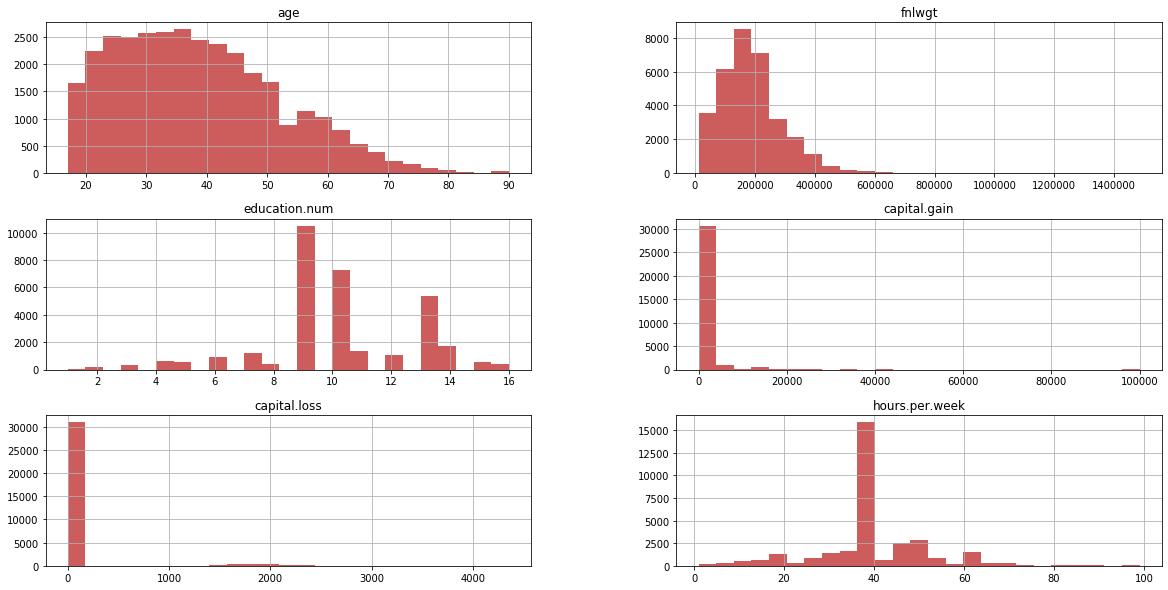

In [8]:
df.hist(bins=25,figsize=(20,10),color='indianred')
plt.show()

**We can see below that the target `income` is imbalanced. This can cause that our model is biased to the majority category which is "<=50K".** 

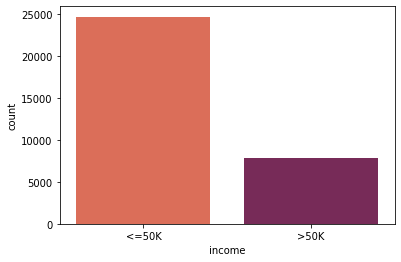

In [9]:
sns.countplot(x=df["income"],palette="rocket_r")

### 2.2 In depth exploration 

#### *2.2.1 train-test-split*

**We will do some further exploration on the training set and put the test set aside.**

In [10]:
X=df.drop("income",axis=1)
y=df["income"]

**Because of the imbalanced target, I will do a stratisfied train-test-split. So that train and test set have the same target `income` ratio. The reason that we split this early, is that we don't want to have any leak from our testdata to training data. Our testdata will truly be "unseen". If we split much later, it is possible that we get super high accuracies, but only because our model "saw" our testdata.**

In [11]:
#Stratisfy to  not only have yesses in splits.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

**Let's create a copy of the training set so we can not harm the original one**

In [12]:
rootset=pd.concat([X_train,y_train],axis=1)

*I will also already create a copy of the testset.*

In [13]:
testset=pd.concat([X_test,y_test],axis=1)

#### *2.2.2 Gaining insights with visualizations*

**At first glance there seem to be no missing values**

In [14]:
rootset.isnull().sum() 

age               0
workclass         0
fnlwgt            0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
income            0
dtype: int64

**However, we see a lot of "?". It seems that missing values were marked with a "?"**

In [15]:
for i in rootset.columns:
    print(rootset[i].value_counts())
    print('----')

36    736
34    722
35    710
31    710
30    702
     ... 
83      5
88      3
85      2
86      1
87      1
Name: age, Length: 73, dtype: int64
----
Private             18160
Self-emp-not-inc     2030
Local-gov            1686
?                    1472
State-gov            1040
Self-emp-inc          890
Federal-gov           753
Without-pay            13
Never-worked            4
Name: workclass, dtype: int64
----
190290    11
155659    11
113364    11
203488    11
164190    11
          ..
188650     1
156000     1
311534     1
307440     1
93169      1
Name: fnlwgt, Length: 18508, dtype: int64
----
HS-grad         8382
Some-college    5835
Bachelors       4261
Masters         1404
Assoc-voc       1108
11th             950
Assoc-acdm       858
10th             741
7th-8th          528
Prof-school      459
9th              420
Doctorate        332
12th             331
5th-6th          266
1st-4th          132
Preschool         41
Name: education, dtype: int64
----
9     8382
10    58

**If we have a deeper look at the description of the numeric variables:**
- age: looks ok, min=17, max=90
- fnlwgt: this variable seems redundant in this dataset. It says something about how many people in the United States have the same socio-economic profile as the subject. But we'll look at a later phase how important this attribute is.
- education: looks ok, min=1, max=16
- capital.gain: seems very skewed to the right (mean=1086, max=99999)
- capital.loss: seems very skewed to the right (mean= 88, max=4356)
- hours.per.week: looks ok, min=1, max=99

In [16]:
rootset.describe() 

,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week
count,26048.000000,2.604800e+04,26048.000000,26048.000000,26048.000000,26048.000000
mean,38.530098,1.902764e+05,10.080505,1086.900683,88.575054,40.420531
std,13.628681,1.061438e+05,2.577431,7413.533054,406.506165,12.325439
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.179830e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.786600e+05,10.000000,0.000000,0.000000,40.000000
75%,47.000000,2.381890e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


**To come back to the missing values, we will replace the "?" with NaN**

In [17]:
rootset=rootset.replace("?",np.nan)

**I will also do it already in the testset**

In [18]:
testset=testset.replace("?",np.nan)

**3 variables have missing values:**
- `occupation` 5.6%
- `workclass` 5.7%
- `native.country` 1.7%

In [19]:
rootset.isnull().sum()/rootset.shape[0]*100

age               0.000000
workclass         5.651106
fnlwgt            0.000000
education         0.000000
education.num     0.000000
marital.status    0.000000
occupation        5.666462
relationship      0.000000
race              0.000000
sex               0.000000
capital.gain      0.000000
capital.loss      0.000000
hours.per.week    0.000000
native.country    1.716063
income            0.000000
dtype: float64

**`occupation` and `workclass` have a similar percentage of missing values. In the below summary, you can see that the rows of missing values often overlap.**

In [20]:
rootset.loc[rootset["workclass"].isnull()]

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
27695,72,NaN,188009,7th-8th,4,Divorced,NaN,Not-in-family,White,Male,0,0,30,United-States,<=50K
28011,61,NaN,42938,Bachelors,13,Never-married,NaN,Not-in-family,White,Male,0,0,7,United-States,>50K
21663,43,NaN,35523,Assoc-acdm,12,Divorced,NaN,Not-in-family,White,Female,0,0,35,United-States,<=50K
2006,19,NaN,200790,12th,8,Married-civ-spouse,NaN,Other-relative,White,Female,15024,0,40,United-States,>50K
32069,60,NaN,268954,Some-college,10,Married-civ-spouse,NaN,Husband,White,Male,0,0,12,United-States,>50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19432,63,NaN,331527,HS-grad,9,Married-civ-spouse,NaN,Husband,White,Male,0,0,14,United-States,<=50K
22965,37,NaN,299090,HS-grad,9,Divorced,NaN,Not-in-family,White,Female,0,0,30,United-States,<=50K
24619,19,NaN,158603,10th,6,Never-married,NaN,Own-child,Black,Male,0,0,25,United-States,<=50K
1510,27,NaN,501172,Some-college,10,Married-civ-spouse,NaN,Husband,White,Male,0,419,20,Mexico,<=50K


**Like we saw before, we have more low earners in our dataset than high earners**

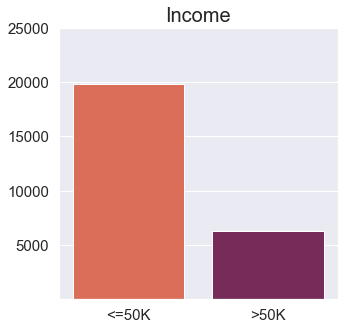

In [21]:
sns.set(rc={'figure.figsize':(5,5)})

figure=sns.countplot(x="income",data=rootset,palette="rocket_r",order=["<=50K", ">50K"])
figure.axes.set_title("Income",fontsize=20)
figure.set_xlabel("",fontsize=20)
figure.set_ylabel("",fontsize=20)
figure.tick_params(labelsize=15)
figure.set(yticks=[5000,10000,15000,20000,25000])
plt.show()
#https://seaborn.pydata.org/generated/seaborn.countplot.html

**The gender variable looks also imbalanced. This indicates that there could be a bias towards male subjects in this dataset**

In [22]:
df["sex"].value_counts(normalize=True)

Male      0.669205
Female    0.330795
Name: sex, dtype: float64

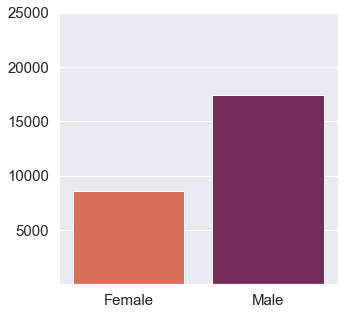

In [23]:
sns.set(rc={'figure.figsize':(5,5)})
figure.axes.set_title("Sex",fontsize=20)
figure=sns.countplot(x="sex",data=rootset,palette="rocket_r")

figure.set_xlabel("",fontsize=20)
figure.set_ylabel("",fontsize=20)
figure.tick_params(labelsize=15)
figure.set(yticks=[5000,10000,15000,20000,25000])
plt.show()

**However, when I had a look at other data from www.census.gov, more men than women were present in the workforce in 1994 (the year this dataset is from). The ratio was never 1:1. Although the ratio in this dataset is still off from the real number, it's still more representative than I initially thought.**

-----


<div>
<img src="1994_gender_workforce.PNG" width="400"/>
</div>

**In the below plot I graphed the `income` against `sex`. We can see that the wagegap is bigger on the left (women) than on the right (men).**

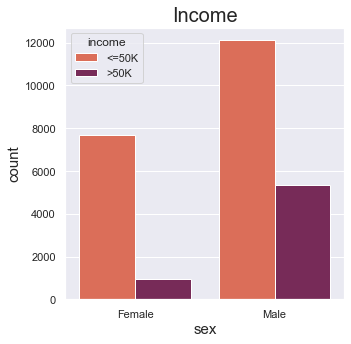

In [24]:
sns.set(rc={'figure.figsize':(5,5)})

figure=sns.countplot(x="sex",data=rootset,palette="rocket_r",hue="income",hue_order=["<=50K",">50K"])
figure.axes.set_title("Income",fontsize=20)
figure.set_xlabel("sex",fontsize=15)
figure.set_ylabel("count",fontsize=15)
plt.show()

**If we graph `income` against `hours.per.week`, it looks like the median of `hours.per.week` for high-earners is higher than
the low-earners. So we can conclude that if you work longer hours, that you're likely to earn more.**

**We can also see in this graph that the interquartile range for low-earners is smaller than for high earners. This means that 50% of the low earners seem to have a more strict workschedule than 50% of the high earners.**

**In both boxplots, we also see a lot of outliers. But they don't seem like impossible values. Some people work more and some people work less.**

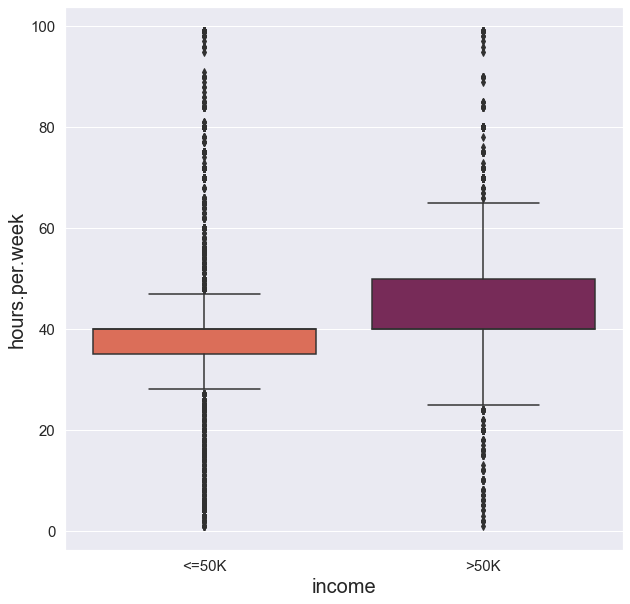

In [25]:
sns.set(rc={'figure.figsize':(10,10)})
figure=sns.boxplot(y="hours.per.week",x="income",data=rootset,palette="rocket_r",order=["<=50K", ">50K"])
figure.tick_params(labelsize=15)
figure.set_xlabel("income",fontsize=20)
figure.set_ylabel("hours.per.week",fontsize=20)
plt.show()
#https://seaborn.pydata.org/generated/seaborn.boxplot.html

**In the below graph, it seems that high earners seem to be older in general than low earners. If we look at the median of age, then the median for low earners is 34 years and for high earners is 43 years. This seems to indicate, the longer you have been on the job market, the more money you earn.**

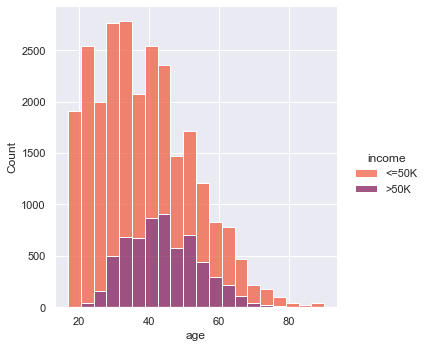

In [26]:
sns.displot(rootset, x="age", hue="income",palette="rocket_r",bins=20,hue_order=["<=50K",">50K"],multiple="stack")
#https://seaborn.pydata.org/generated/seaborn.distplot.html

In [27]:
rootset[rootset['income'] == ">50K"].age.median()

43.0

In [28]:
rootset[rootset['income'] == "<=50K"].age.median()

34.0

**In below figure we can see a very big income gap in the variable `relationship` for the categories "own-child", "Not-in-family","Unmarried","Other-relative". Basically it seems that if you are not married, you are less probable to earn more than 50K.**

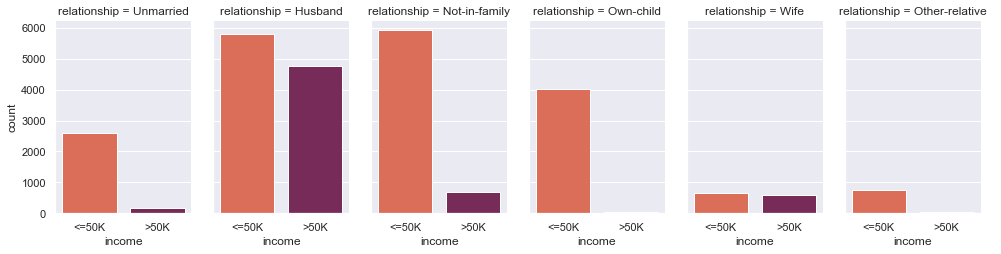

In [29]:
g = sns.FacetGrid(rootset, col="relationship",height=3.5, aspect=.65)
g.map_dataframe(sns.countplot, x="income",palette="rocket_r",order=["<=50K", ">50K"])
g.set_axis_labels("income", "count")
g.add_legend()
#https://seaborn.pydata.org/generated/seaborn.FacetGrid.html

**In below figure we can see that you are more likely to earn more than 50k, if you are married, which confirms the graph above.**

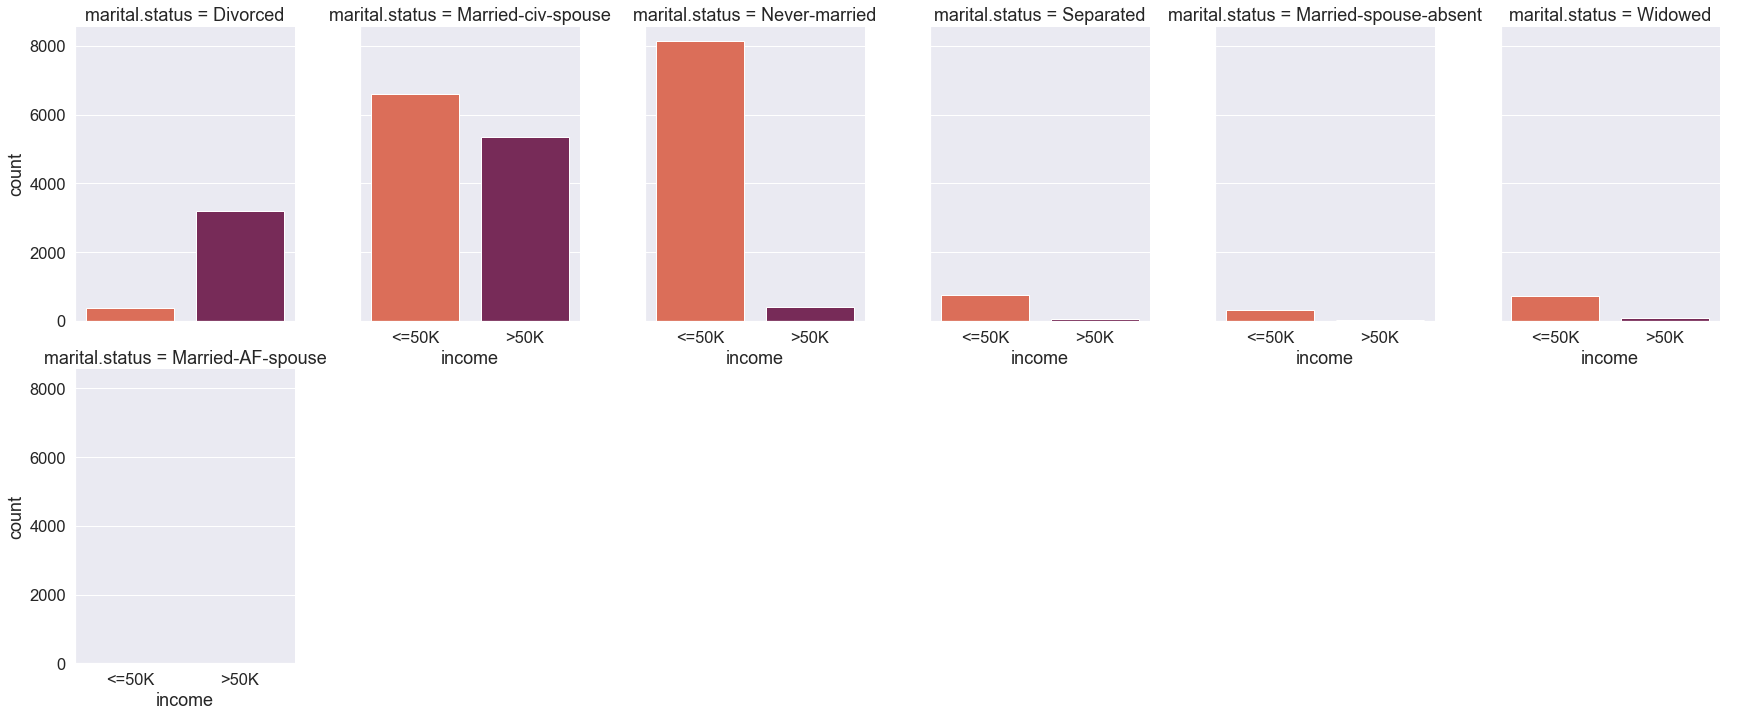

In [30]:
sns.set(font_scale=1.5)
g = sns.FacetGrid(rootset, col="marital.status",height=5, aspect=.8,sharex=True,col_wrap=6)
g.map_dataframe(sns.countplot, x="income",palette="rocket_r")
g.set_axis_labels("income", "count")
g.add_legend()

#https://seaborn.pydata.org/generated/seaborn.FacetGrid.html
#https://stackoverflow.com/questions/25328003/how-can-i-change-the-font-size-using-seaborn-facetgrid

**If we graph `income` against `occupation`, and `occupation` against `hours.per.week`:**
- The best-paying jobs are in "exec-managerial" and "prof_specialty"
- 50% of the farmers-fishers work between 40-90 hours per week (excluding outliers) and their income is less than 50k
- Most people that are in administration work between 35-45 hours per week and their income is less than 50k
- It seems that it's better to work in administration than in farming if the pay is the same.
- Every job has its outliers, but farming-fishing seems to be the most intensive job. 50% works less than 40h, while the other 50% can work up to 99 hours. I do wonder if this number is capped.
- jobs with the most consistent(reasonable hours (Q3=40h)) are Adm-clerical and handlers/cleaners
- the only job that seems consistent with almost no outliers are the armed forces, but there also only 6 datapoints for them.

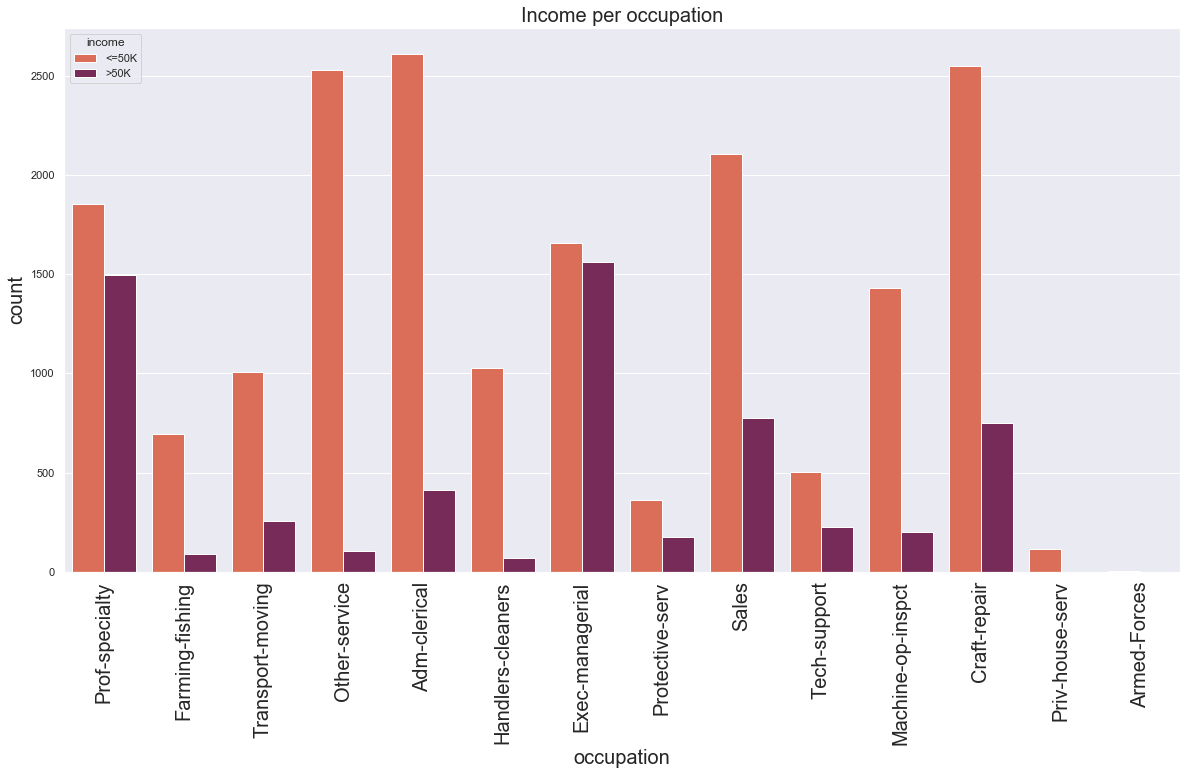

In [31]:
sns.set(rc={'figure.figsize':(20,10)})

figure=sns.countplot(x="occupation",data=rootset,palette="rocket_r",hue="income",hue_order=["<=50K",">50K"])
figure.axes.set_title("Income per occupation",fontsize=20)
figure.set_xticklabels(figure.get_xticklabels(),rotation=90,fontsize=20)
figure.set_xlabel("occupation",fontsize=20)
figure.set_ylabel("count",fontsize=20)
plt.show()

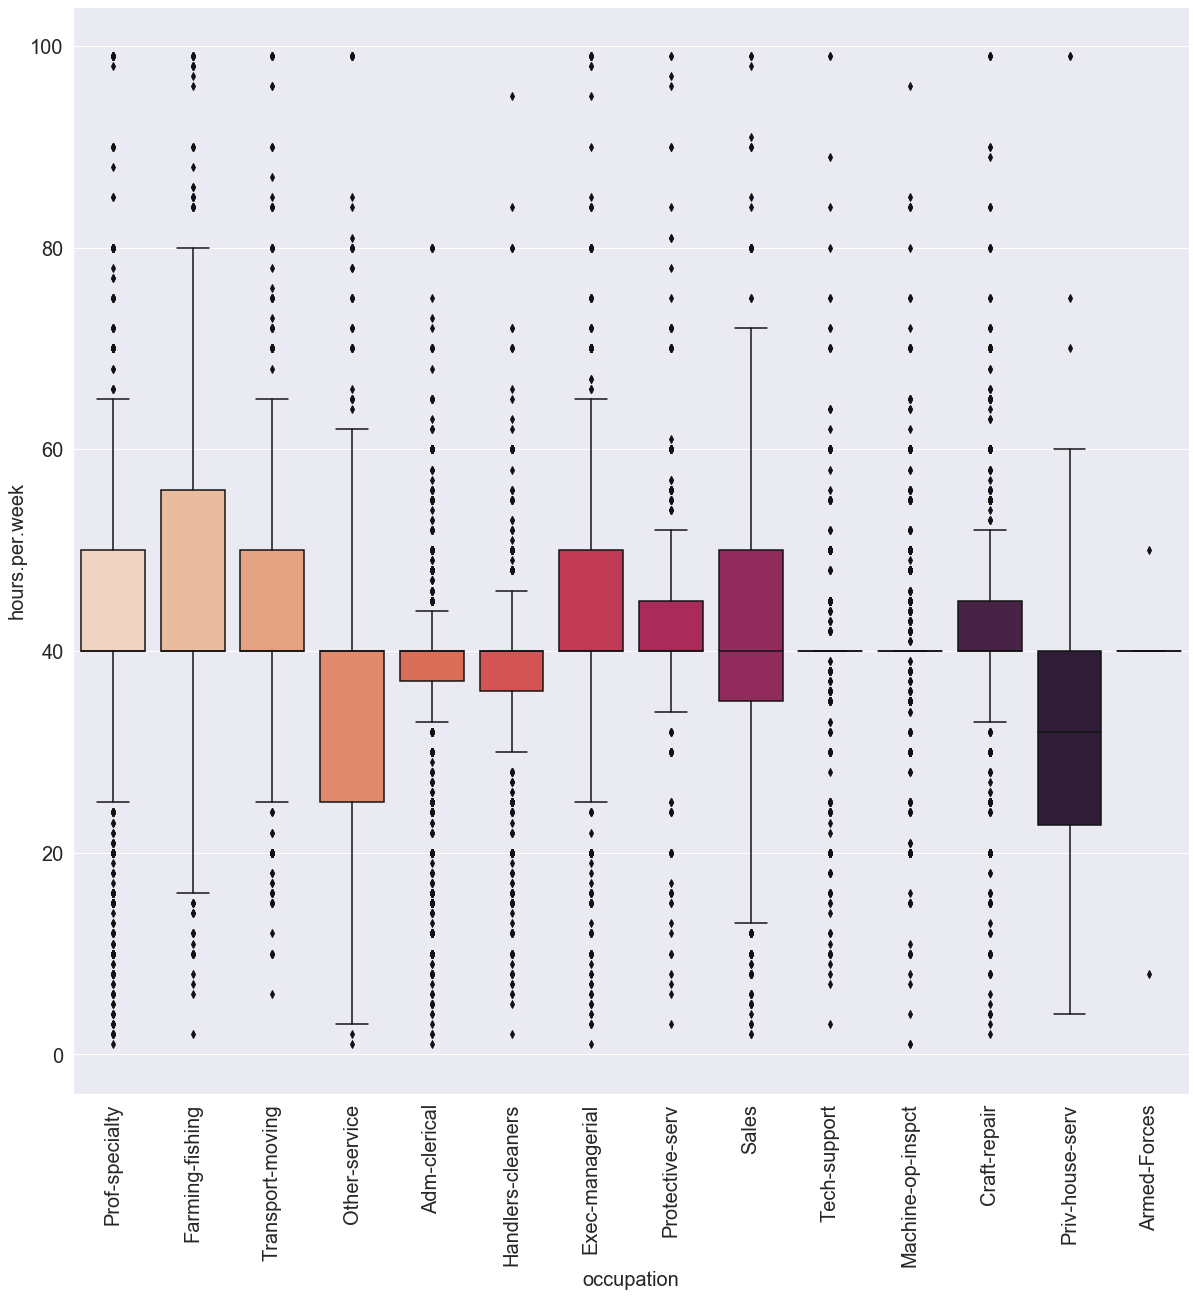

In [32]:
sns.set(rc={'figure.figsize':(20,20)})
figure=sns.boxplot(y="hours.per.week",x="occupation",data=rootset,palette="rocket_r")
figure.set_xticklabels(figure.get_xticklabels(),rotation=90)
figure.tick_params(labelsize=20)
figure.set_xlabel("occupation",fontsize=20)
figure.set_ylabel("hours.per.week",fontsize=20)
plt.show()

**If we look at income per race, white people seem more likely to earn more than all the other races. This is also due to the huge disparity of races in this dataset. In a later stage I will check what the impact is on accuracy and precision when I drop this variable.**

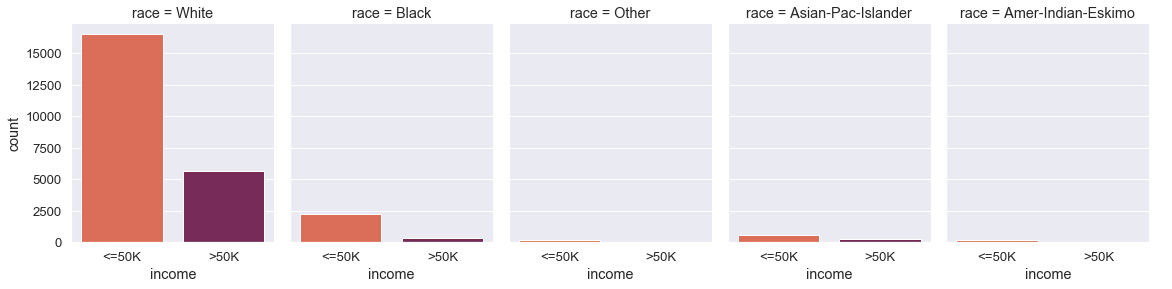

In [33]:
sns.set(font_scale=1.2)
g = sns.FacetGrid(rootset, col="race",height=4, aspect=.8)
g.map_dataframe(sns.countplot, x="income",palette="rocket_r",order=["<=50K", ">50K"])
g.set_axis_labels("income", "count")
g.add_legend()

#https://seaborn.pydata.org/generated/seaborn.FacetGrid.html

In [34]:
rootset["race"].value_counts(normalize=True)

White                 0.851850
Black                 0.097704
Asian-Pac-Islander    0.032363
Amer-Indian-Eskimo    0.009367
Other                 0.008715
Name: race, dtype: float64

**However, when I had a look at the percentage of races in America (www.census.gov), caucasian people are the most prevalent. In 2019, 76.3% of the population is white. While 13.4% of the population was black.**

**If we look at the race division between white and black in our dataset, 85.2% is white and 9.8% is black. The disparity between races seemed bigger in 1994, however this was expected. Over the years many more people migrated. So I think that the dataset is representative for the race population of the USA in 1994.**

----


<div>
<img src="2019_race_population.PNG" width="700"/>
</div>

**If we graph `hours.per.week` to `income` we can see that most people work around 40 hours in both low-earners and high earners categories. We also see that the workhours for the low earners are more spead out than the high earners.** 

**I will bin this variable in the section "Transformations" to make it discrete and to help deal with the outliers (people that work more than 80 hours).**




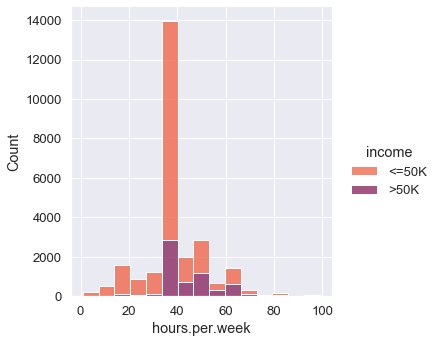

In [35]:
sns.displot(rootset, x="hours.per.week", hue="income",palette="rocket_r",bins=15,hue_order=["<=50K",">50K"],multiple="stack")

**Let's have look at the graph if we bin the continous variable `hours.per.week` in:**

- Less than 35 hours
- 35-44 hours
- 45-64 hours
- 65+ hours

In [36]:
rootset_c=rootset.copy()

ranges = [0,34,44,64,np.inf]  # np.inf for infinity
labels = ["less than 35 hours","35-44 hours","45-64 hours","65+ hours"]
rootset_c["hours"]=pd.cut(rootset["hours.per.week"], 
                                  bins=ranges, 
                                  labels=labels,right=True)
#https://towardsdatascience.com/how-i-customarily-bin-data-with-pandas-9303c9e4d946

**In the below graph the relationship is more clear if we bin it in categorical variables. We can clearly see that people who work less more than 35 hours are less likely to earn more than 50K. On the other hand, we see that the gap above 65 hours is smaller.**

Text(0, 0.5, 'count')

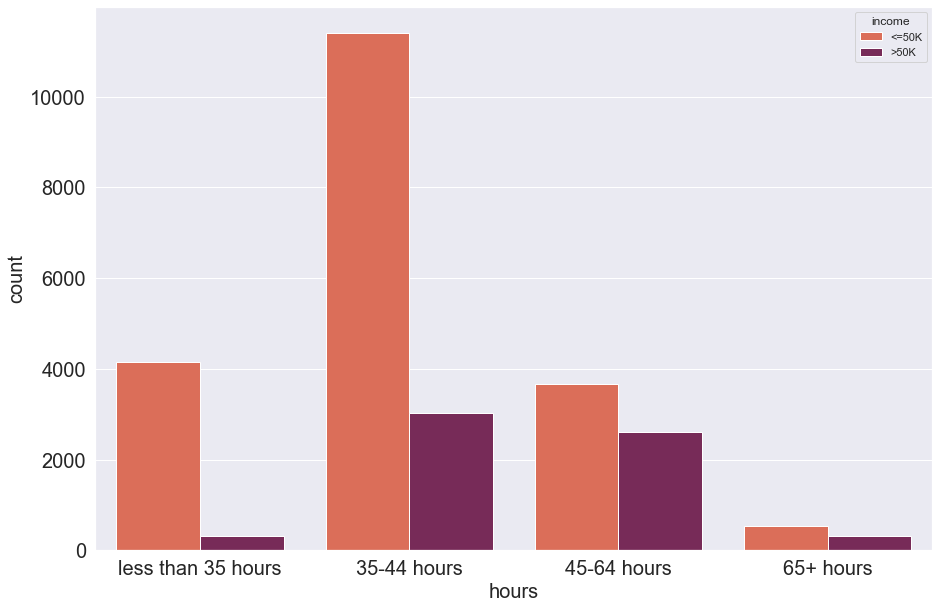

In [37]:
sns.set(rc={'figure.figsize':(15,10)})
figure=sns.countplot(x=rootset_c["hours"],hue=rootset_c["income"],palette="rocket_r",hue_order=["<=50K",">50K"])
figure.tick_params(labelsize=20)
figure.set_xlabel("hours",fontsize=20)
figure.set_ylabel("count",fontsize=20)

**In the graph below we can see that the ratio >50K/<=50K is greater when you have done a Masters, Prof-school or a Doctorate.**

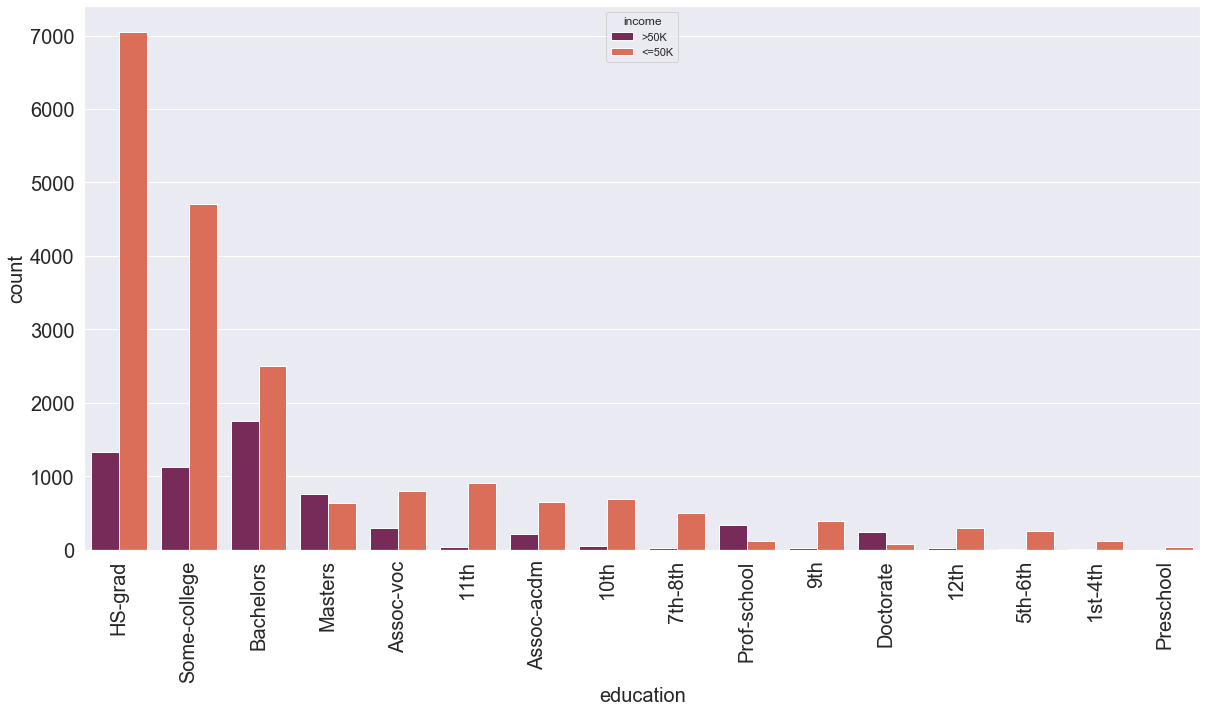

In [38]:
sns.set(rc={'figure.figsize':(20,10)})

#figure=sns.histplot(x="occupation",data=rootset,palette="rocket_r",hue="income",multiple="stack")
figure=sns.countplot(x="education",data=rootset,order=rootset['education'].value_counts().index,palette="rocket",hue="income")
figure.set_xticklabels(figure.get_xticklabels(),rotation=90)
figure.tick_params(labelsize=20)
figure.set_xlabel("education",fontsize=20)
figure.set_ylabel("count",fontsize=20)
plt.show()

**However, I wonder if we can see a more clear relationship between the different categories if I bin them in:**
    - less than highschool
    - high school
    - some college
    - bachelor's degree or higher

In [39]:
rootset_c["education"]=rootset_c["education"].replace("HS-grad","high school")
rootset_c["education"]=rootset_c["education"].replace(["Some-college","Assoc-voc","Assoc-acdm"],"some college")
rootset_c["education"]=rootset_c["education"].replace(["Bachelors","Masters","Prof-school","Doctorate"],"bachelor's degree or higher")
rootset_c["education"]=rootset_c["education"].replace(["11th","10th","7th-8th","9th","12th","5th-6th","1st-4th","Preschool"],"less than high school")

**Indeed, a more clear relationship can be seen. The ratio of income in the category "bachelor's degree or higher" is almost 50:50 between the low and high-earners. However, what we also notice is that the ratio of income between the category "high school" and "some college" seems almost similar.**
- high school:
        - under 50K           0.842603
        - above 50K           0.157397
- some college:
        - under 50K           0.791629
        - above 50K           0.208371
        
**We can conclude from this that college does not always lead to a higher income. However, starting from a bachelor's degree, chances do increase to have an income higher than 50K.** 

Text(0, 0.5, 'count')

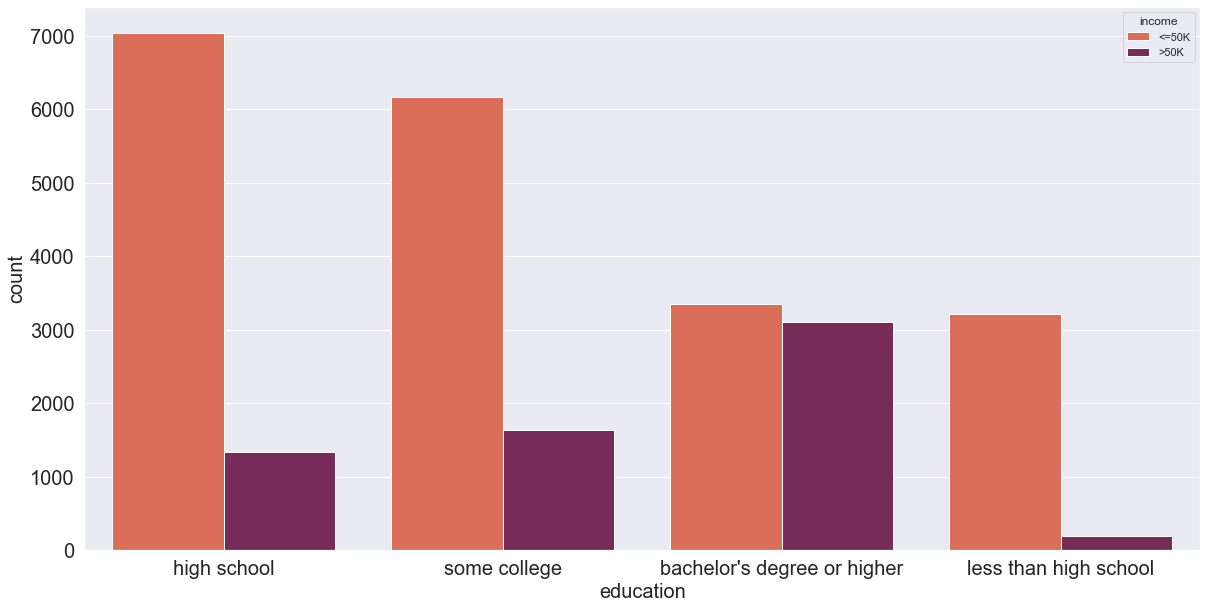

In [40]:
sns.set(rc={'figure.figsize':(20,10)})
figure=sns.countplot(data=rootset_c,x="education",order=rootset_c['education'].value_counts().index,palette="rocket_r",hue=rootset_c["income"],hue_order=["<=50K",">50K"])
figure.tick_params(labelsize=20)
figure.set_xlabel("education",fontsize=20)
figure.set_ylabel("count",fontsize=20)

**I will do this transformation in the section "Transformations".**

<div class="alert alert-block alert-success">
<b>What we can conclude from the above graphs is that you are likely to earn more than 50K dollars when you are</b>  
    a white married middle-aged man that has a higher education diploma and work hard in your high profile job.
</div>




#### *2.2.3 Univariate plots*

**`age` seems not to be normally distributed. It looks a bit skewed to the right. The stats.normaltest confirms that it is not normally distributed.**

In [41]:
stats.normaltest(rootset["education.num"]) 

NormaltestResult(statistic=647.2414831770592, pvalue=2.839865022147671e-141)

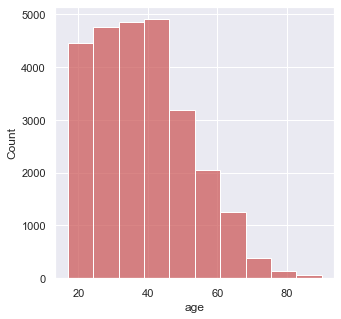

In [42]:
sns.set(rc={'figure.figsize':(5,5)})
sns.histplot(data=rootset,x="age",color="indianred",bins=10)

**I'm going to bin age in 4 categories:**
- 16-29
- 30-44
- 45-59
- 60+

**This step will be done in the section "Transformations".**

In [43]:
ranges = [16,29,44,59,np.inf]  # np.inf for infinity
labels = ["16-29","30-44","45-59","60+"]
rootset_c["age_cat"] = pd.cut(rootset_c["age"], 
                                  bins=ranges, 
                                  labels=labels,right=True)
#https://towardsdatascience.com/how-i-customarily-bin-data-with-pandas-9303c9e4d946

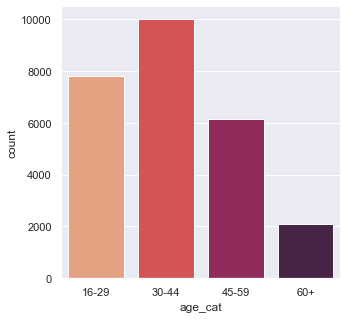

In [44]:
sns.countplot(x=rootset_c["age_cat"],palette="rocket_r")

**The dataset has a high count of people that are in prof-specialty, craft-repair and exec-managerial jobs.**

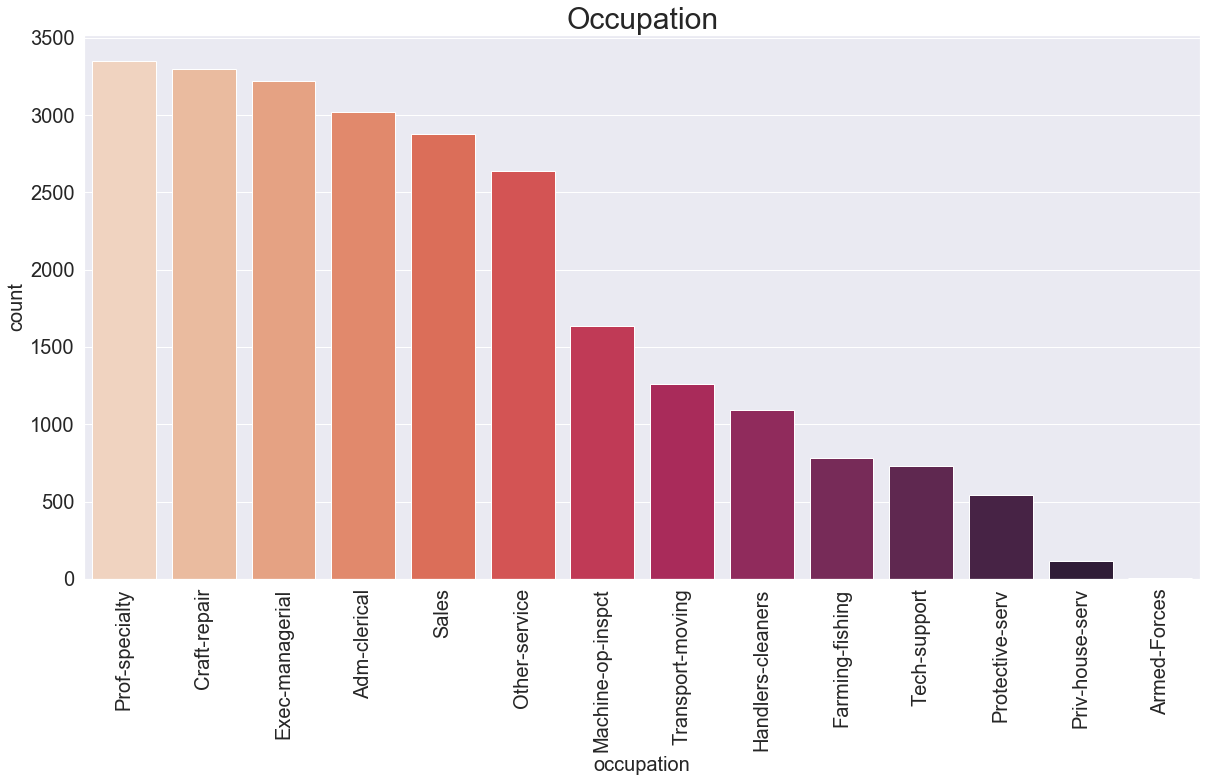

In [45]:
sns.set(rc={'figure.figsize':(20,10)})

figure=sns.countplot(data=rootset,x="occupation",order=rootset['occupation'].value_counts().index,palette="rocket_r")
figure.set_xticklabels(figure.get_xticklabels(),rotation=90)
figure.axes.set_title("Occupation",fontsize=30)
figure.set_xlabel("occupation",fontsize=20)
figure.set_ylabel("count",fontsize=20)
figure.tick_params(labelsize=20)

#https://stackoverflow.com/questions/48043365/how-to-improve-this-seaborn-countplot
#https://www.youtube.com/watch?time_continue=381&v=fXff4-_3Ey0&feature=emb_logo

**In the below graph you can see that most people in this dataset work in the private sector. I also see 2 times "self-employed" and 3 times variations of working at the "government". So, I'm going to combine the variations . Then there are also the categories "without-pay" and "never-worked". They seem to be different, but actually they say that don't earn a salary which is important to know if the bank wants to grant loans. Therefore I will put these 2 in one category "no pay". I will do this step in the section "Tranformations".** 

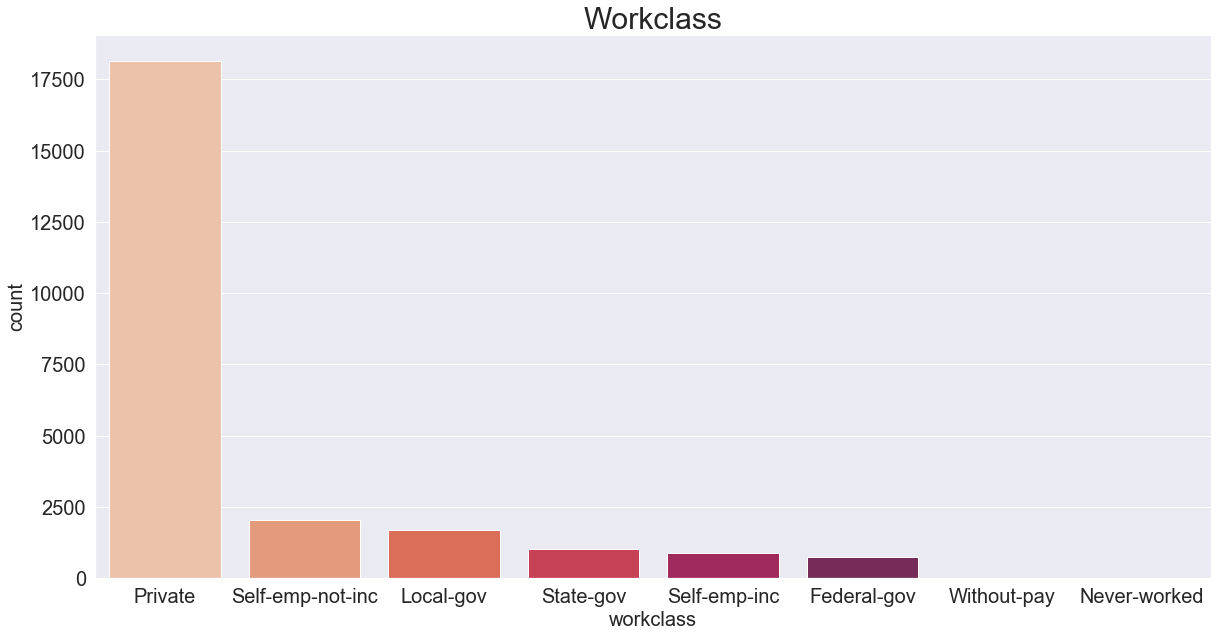

In [46]:
sns.set(rc={'figure.figsize':(20,10)})

figure=sns.countplot(data=rootset,x="workclass",order=rootset['workclass'].value_counts().index,palette="rocket_r")
figure.axes.set_title("Workclass",fontsize=30)
figure.set_xlabel("workclass",fontsize=20)
figure.set_ylabel("count",fontsize=20)
figure.tick_params(labelsize=20)

#https://stackoverflow.com/questions/48043365/how-to-improve-this-seaborn-countplot
#https://www.youtube.com/watch?time_continue=381&v=fXff4-_3Ey0&feature=emb_logo

**The `native.country` variable has a lot of countries. United States is the most prominent one. Because the other countries don't have a lot of data, it will be difficult to learn something from them. So we are going to group all non-US countries together. I will already do the transformation here, so we don't need to deal with one-hot-encoding when we want to create a base model.**

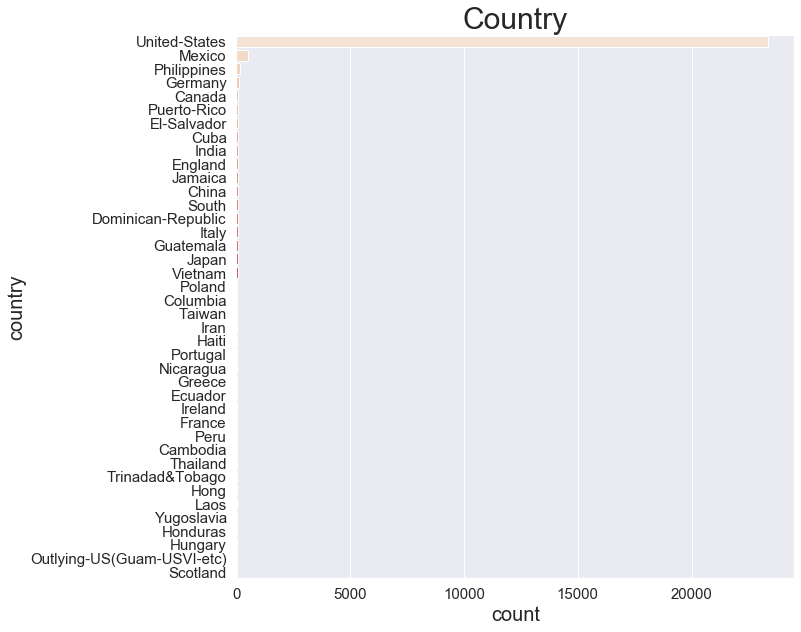

In [47]:
sns.set(rc={'figure.figsize':(10,10)})

figure=sns.countplot(data=rootset,y="native.country",order=rootset['native.country'].value_counts().index,palette="rocket_r")
figure.axes.set_title("Country",fontsize=30)
figure.set_xlabel("count",fontsize=20)
figure.set_ylabel("country",fontsize=20)
figure.tick_params(labelsize=15)

#https://stackoverflow.com/questions/48043365/how-to-improve-this-seaborn-countplot
#https://www.youtube.com/watch?time_continue=381&v=fXff4-_3Ey0&feature=emb_logo

In [48]:
country= ['Mexico', 'Greece', 'Vietnam', 'China',
       'Taiwan', 'India', 'Philippines', 'Trinadad&Tobago', 'Canada',
       'South', 'Holand-Netherlands', 'Puerto-Rico', 'Poland', 'Iran',
       'England', 'Germany', 'Italy', 'Japan', 'Hong', 'Honduras', 'Cuba',
       'Ireland', 'Cambodia', 'Peru', 'Nicaragua', 'Dominican-Republic',
       'Haiti', 'El-Salvador', 'Hungary', 'Columbia', 'Guatemala',
       'Jamaica', 'Ecuador', 'France', 'Yugoslavia', 'Scotland',
       'Portugal', 'Laos', 'Thailand', 'Outlying-US(Guam-USVI-etc)']

In [49]:
for i in country:
    rootset["native.country"]=rootset["native.country"].replace(i,"non United-States")

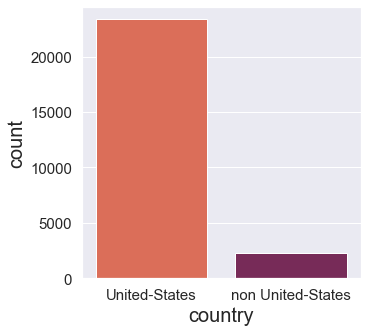

In [50]:
sns.set(rc={'figure.figsize':(5,5)})

figure=sns.countplot(data=rootset,x="native.country",order=rootset['native.country'].value_counts().index,palette="rocket_r")
figure.set_xlabel("country",fontsize=20)
figure.set_ylabel("count",fontsize=20)
figure.tick_params(labelsize=15)

**I will also do it already for the testset**

In [51]:
for i in country:
    testset["native.country"]=testset["native.country"].replace(i,"non United-States")

**`hours.per.week` is not normally distributed according to the normaltest. Values at 40 hours (median) are also skyrocketing.**

NormaltestResult(statistic=2048.5341063163532, pvalue=0.0)

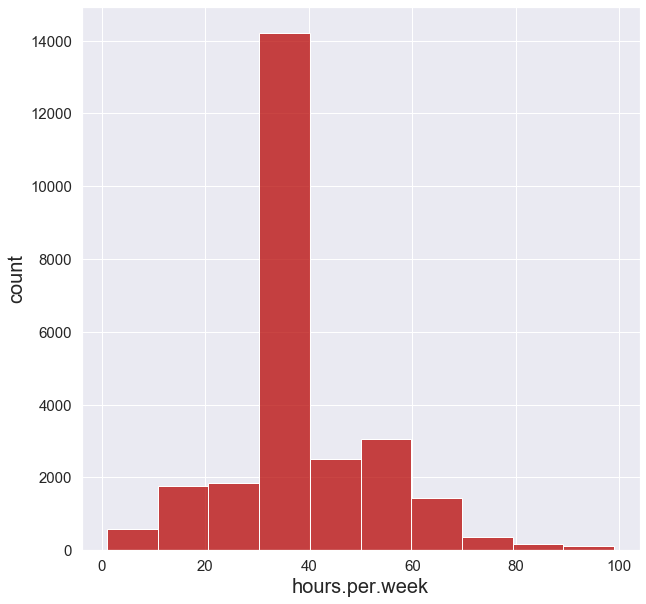

In [52]:
sns.set(rc={'figure.figsize':(10,10)},palette="OrRd_r")
figure=sns.histplot(rootset["hours.per.week"],bins=10)
figure.set_xlabel("hours.per.week",fontsize=20)
figure.set_ylabel("count",fontsize=20)
figure.tick_params(labelsize=15)

stats.normaltest(rootset["hours.per.week"]) 

**`capital.loss` and `capital.gain` are not normally distributed. Most values are 0. Like I said before, this can indicate that most people did not do any investments. We also see that `capital.gain` is capped at 99999. This can be the real value, or the real value can also be higher. But let's have a look at the distribution if the value 0 is excluded.**

`capital.gain` before removing zeroes

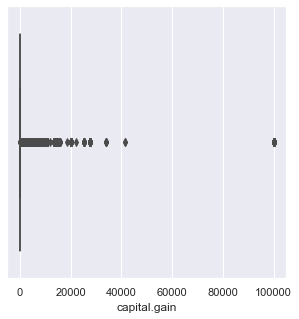

In [53]:
sns.set(rc={'figure.figsize':(5,5)})
sns.boxplot(x=rootset["capital.gain"])

**If we don't pay attention to the 0 values, the median is 7298**

In [54]:
rootset[rootset["capital.gain"]!=0].median()

age                   43.0
fnlwgt            176240.0
education.num         11.0
capital.gain        7298.0
capital.loss           0.0
hours.per.week        40.0
dtype: float64

`capital.gain` after removing zeroes

**When we exclude the zeroes, we can see a more expanded boxplot, with a strong outlier at 99999.**

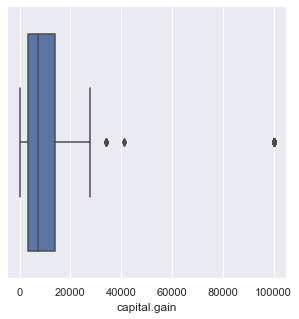

In [55]:
sns.boxplot(data=rootset[rootset["capital.gain"]!=0],x="capital.gain")

`capital.loss` before removing zeroes

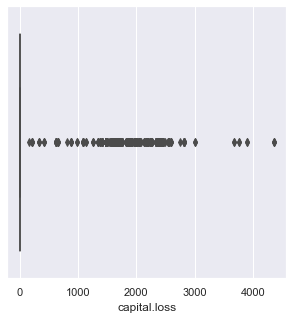

In [56]:
sns.boxplot(x=rootset["capital.loss"])

**If we don't pay attention to the 0 values, the median is 1887**

In [57]:
rootset[rootset["capital.loss"]!=0].median()

age                   41.0
fnlwgt            174901.0
education.num         10.0
capital.gain           0.0
capital.loss        1887.0
hours.per.week        40.0
dtype: float64

`capital.loss` after removing zeroes

**When we exclude the zeroes, we can see a more expanded boxplot with some outliers. They don't seem like extreme impossible values.**

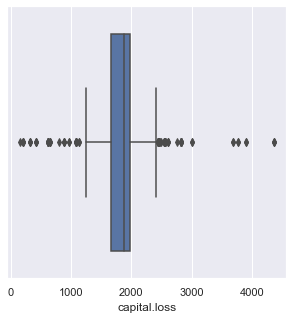

In [58]:
sns.boxplot(data=rootset[rootset["capital.loss"]!=0],x="capital.loss")

**`capital.gain` and `capital.loss` are both variables that say something regarding wins and losses of investments. Therefore we will combine the 2 attributes to one attribute `capital_net_gain`.**

In [59]:
rootset["capital_net_gain"]=rootset["capital.gain"]-rootset["capital.loss"]

In [60]:
rootset=rootset.drop(["capital.gain","capital.loss"],axis=1)

*I will also do this for the testset*

In [61]:
testset["capital_net_gain"]=testset["capital.gain"]-testset["capital.loss"]

In [62]:
testset=testset.drop(["capital.gain","capital.loss"],axis=1)

`capital_net_gain`

**If we now plot this variable, we can see the boxplot has still a very extreme outlier.**

**I thought of binning  `capital_net_gain` in a categorical variable. That way the outliers were also dealt with. But when I carried out this transformation in a future exploration, precision decreased with 5%. So I will not bin them. I will just delete the rows with an outlier at 99999 in the section "Transformations".**

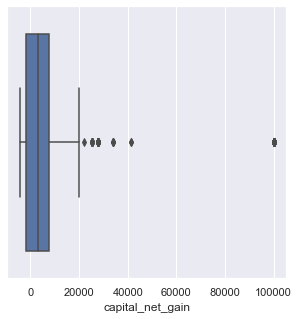

In [63]:
sns.boxplot(data=rootset[rootset["capital_net_gain"]!=0],x="capital_net_gain")

**It seems that some info in `relationship` is also available in `marital.status`. We have to check their correlations  in the correlation phase. Since I'm also planning to make the dataset more genderneutral, I'm going to substitute "husband" and "wife" by "Married". This step will be done in the section "Transformations"**

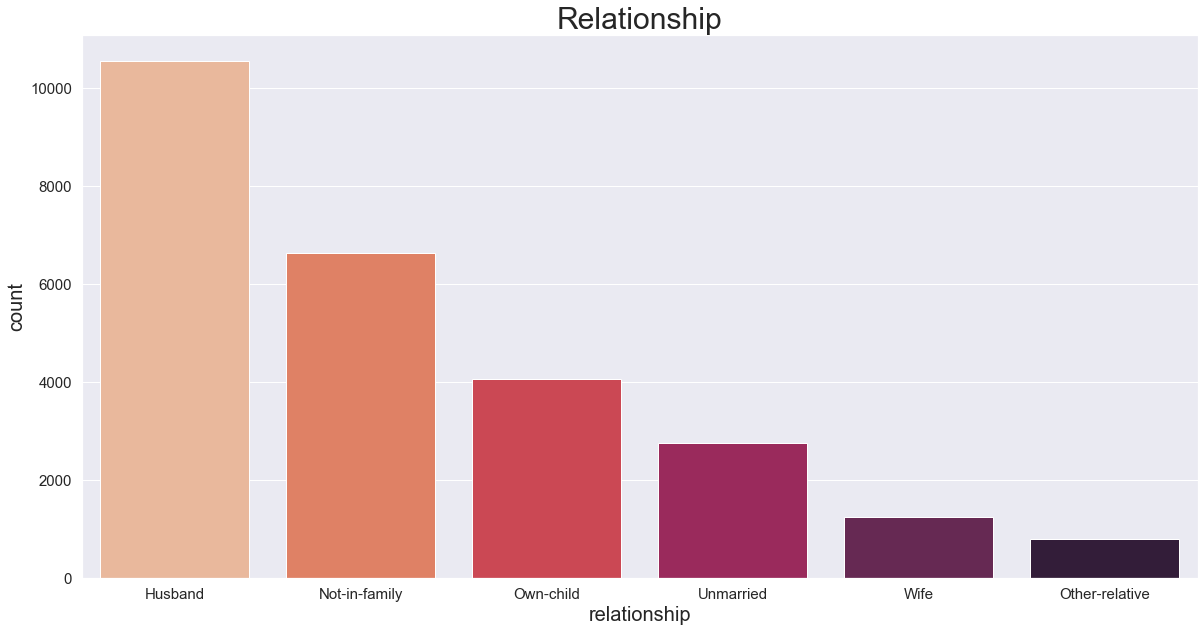

In [64]:
sns.set(rc={'figure.figsize':(20,10)})

figure=sns.countplot(data=rootset,x="relationship",order=rootset['relationship'].value_counts().index,palette="rocket_r")
figure.set_xticklabels(figure.get_xticklabels())
figure.axes.set_title("Relationship",fontsize=30)
figure.set_xlabel("relationship",fontsize=20)
figure.set_ylabel("count",fontsize=20)
figure.tick_params(labelsize=15)

**It seems that in `marital.status` there are 3 main categories: "Married","Not married anymore","Never married". This change will be done in the section "Transformations"**

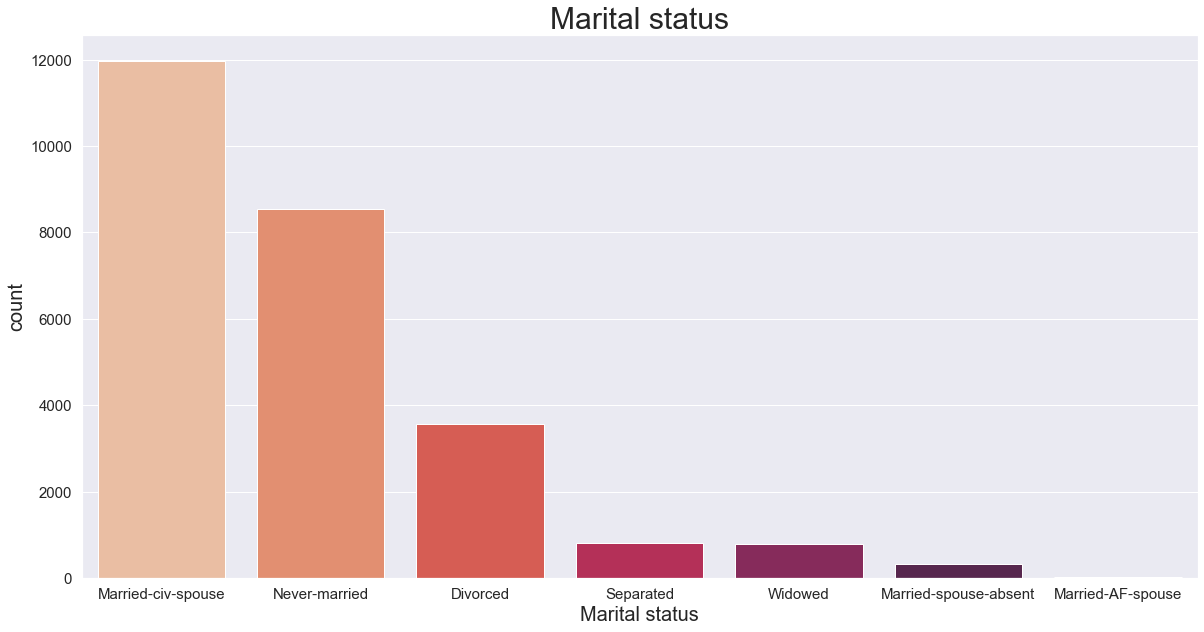

In [65]:
sns.set(rc={'figure.figsize':(20,10)})

figure=sns.countplot(data=rootset,x="marital.status",order=rootset['marital.status'].value_counts().index,palette="rocket_r")
figure.set_xticklabels(figure.get_xticklabels())
figure.axes.set_title("Marital status",fontsize=30)
figure.set_xlabel("Marital status",fontsize=20)
figure.set_ylabel("count",fontsize=20)
figure.tick_params(labelsize=15)

**Most people in this dataset seem to have at least graduated high school**

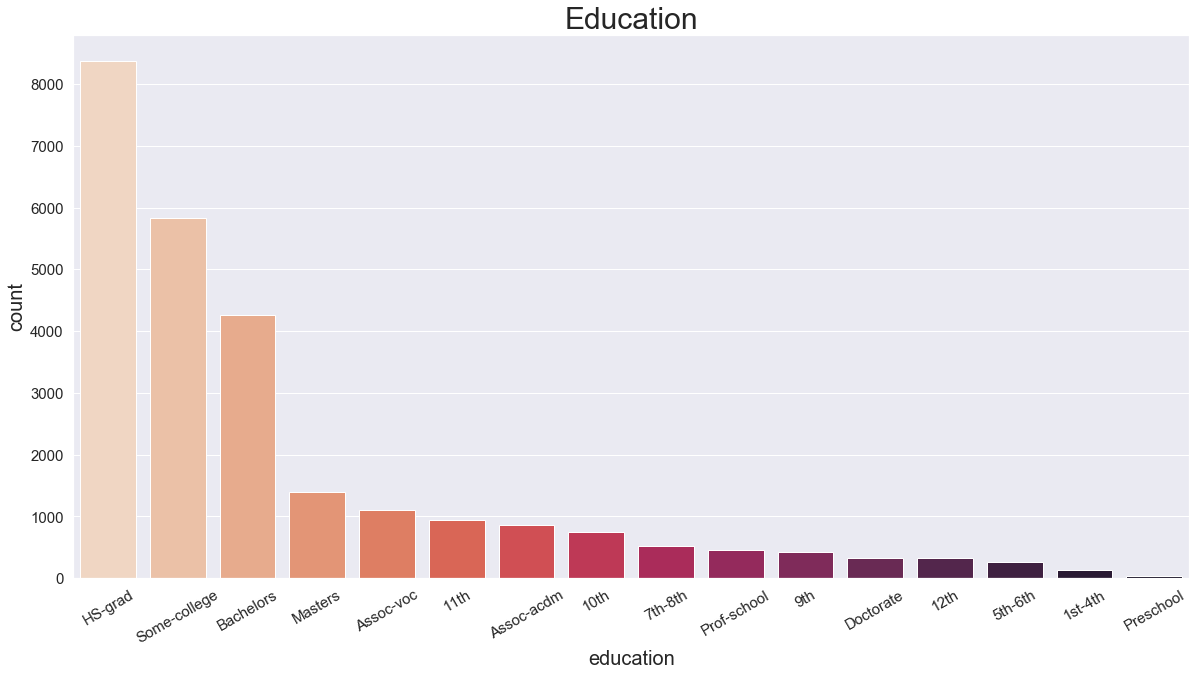

In [66]:
sns.set(rc={'figure.figsize':(20,10)})

figure=sns.countplot(data=rootset,x="education",order=rootset['education'].value_counts().index,palette="rocket_r")
figure.set_xticklabels(figure.get_xticklabels(),rotation=30)
figure.axes.set_title("Education",fontsize=30)
figure.set_xlabel("education",fontsize=20)
figure.set_ylabel("count",fontsize=20)
figure.tick_params(labelsize=15)

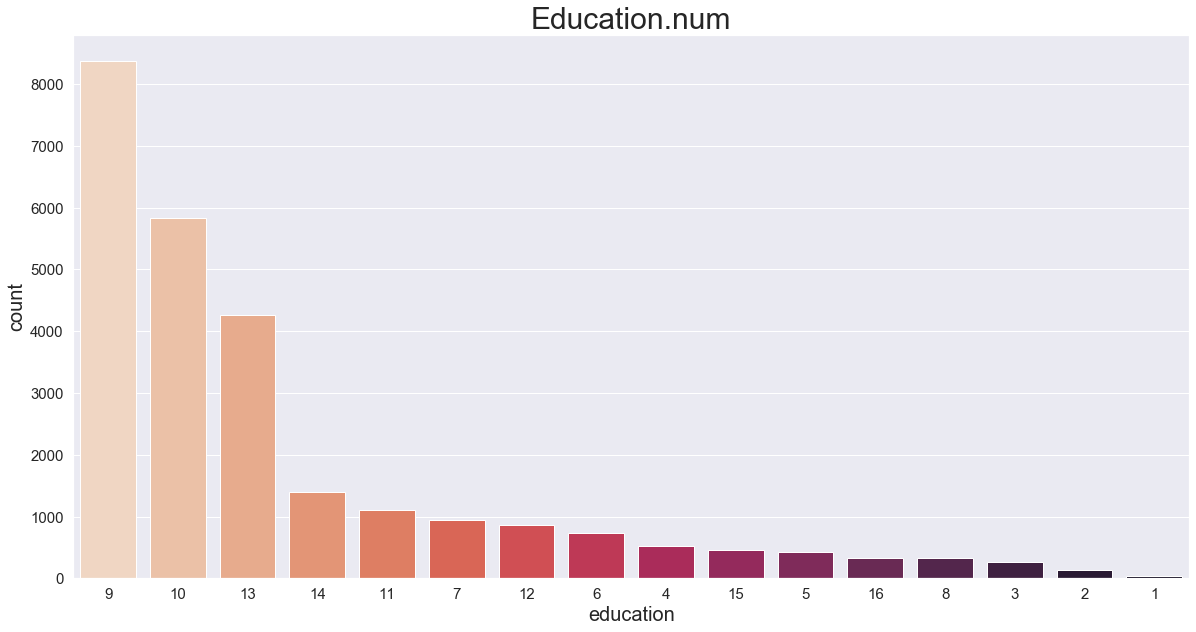

In [67]:
sns.set(rc={'figure.figsize':(20,10)})

figure=sns.countplot(data=rootset,x="education.num",order=rootset['education.num'].value_counts().index,palette="rocket_r")
figure.set_xticklabels(figure.get_xticklabels())
figure.axes.set_title("Education.num",fontsize=30)
figure.set_xlabel("education",fontsize=20)
figure.set_ylabel("count",fontsize=20)
figure.tick_params(labelsize=15)

In [68]:
dython.nominal.correlation_ratio(measurements=rootset["education.num"],categories=rootset["education"])
#http://shakedzy.xyz/dython/modules/nominal/

1.0

**I noticed that education and education.num are identical. The correlation ratio from dython also confirms this. So I will drop "education" here.**

In [69]:
rootset=rootset.drop("education.num",axis=1)

In [70]:
testset=testset.drop("education.num",axis=1)

**There is a good chance that the variable  `fnlwgt` will be dropped, as I don't see any relation with the other variables. But, we will check it in the correlations stage.**

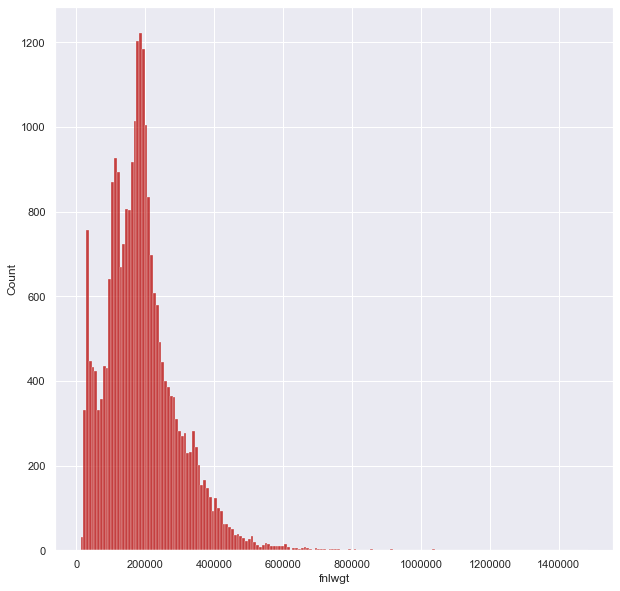

In [71]:
sns.set(rc={'figure.figsize':(10,10)},palette="OrRd_r")
sns.histplot(rootset["fnlwgt"],kde = False)

**To make it myself easier, I'm going to make the target numeric.**

In [72]:
# rootset["income"]=rootset["income"].replace(">50K",1)
# rootset["income"]=rootset["income"].replace("<=50K",0)

In [73]:
# testset["income"]=testset["income"].replace(">50K",1)
# testset["income"]=testset["income"].replace("<=50K",0)

**I will also map the binary variables to 0 and 1.**

## 3. Correlations/associations

### 3.1 numeric-numeric

**To find correlations between numeric variables, I will make use of the Spearman correlation as my numeric variables are not normally distributed.**

In [74]:
corr=rootset.corr(method="spearman")
corr.style.background_gradient(cmap='coolwarm')
#https://stackoverflow.com/questions/29432629/plot-correlation-matrix-using-pandas

,age,fnlwgt,hours.per.week,capital_net_gain
age,1.000000,-0.077050,0.141144,0.063823
fnlwgt,-0.077050,1.000000,-0.020411,-0.001550
hours.per.week,0.141144,-0.020411,1.000000,0.035274
capital_net_gain,0.063823,-0.001550,0.035274,1.000000


**Correlation of numerical variables with eachother:**

- no numerical attributes are highly correlated to each other

### 3.2 numeric - binary (income)

In [75]:
from scipy.stats import pointbiserialr

In [76]:
rootset["income"]=rootset["income"].replace(">50K",1)
rootset["income"]=rootset["income"].replace("<=50K",0)

In [77]:
numeric=["age","fnlwgt","hours.per.week","capital_net_gain"]

In [78]:
rootset_model=pd.DataFrame(columns=["Categorical","Variable","Correlation","P-value"])
for i in numeric:
    rootset_model=rootset_model.append({"Categorical":"income","Variable":i,"Correlation":pointbiserialr(rootset[i], rootset["income"])[0],
                             "P-value":pointbiserialr(rootset[i], rootset["income"])[1]}, ignore_index=True)
print(rootset_model)

#https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.pointbiserialr.html

  Categorical          Variable  Correlation        P-value
0      income               age     0.232564  6.985019e-317
1      income            fnlwgt    -0.007890   2.028933e-01
2      income    hours.per.week     0.230400  6.843323e-311
3      income  capital_net_gain     0.214975  5.621483e-270


**Correlation of numerical variables with `income`:**

- `fnlwgt` has almost a correlation of 0 with income, so we can drop this variable. 
- The other numerical variables seem to have small correlations with `income`

In [79]:
rootset=rootset.drop("fnlwgt",axis=1)

### 3.3 categorical-categorical

**To find assocations between categorical variables, I will make use of Cramer's V. I imported the libary "Dython" to help me with this.**

**The biggest relationship is seen between `relationship` and `sex` (0.65). `sex` does not seem to have a big impact on income. So I will drop this variable. This step will be done in the section "Transformations". Besides it would be discrimination if a bank approves loans based on sex.**

C:\Users\kimmi\OneDrive\Documenten\Data science\python\lib\site-packages\pandas\core\frame.py:4465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


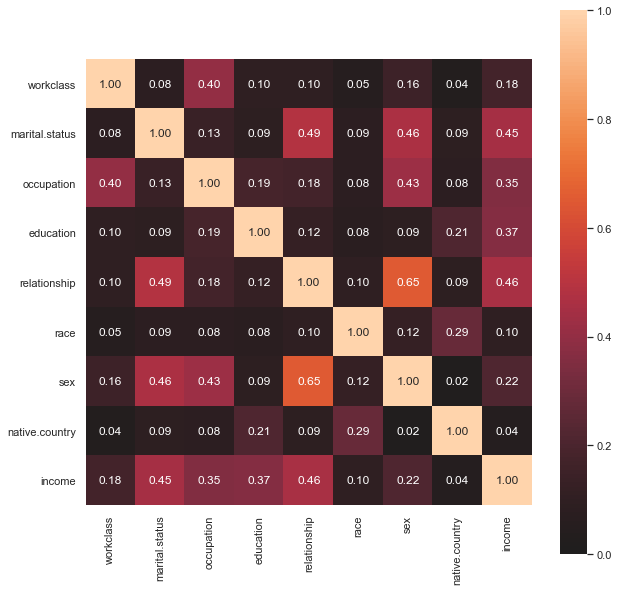

{'corr':                 workclass  marital.status  occupation  education  \
 workclass        1.000000        0.083705    0.399232   0.097920   
 marital.status   0.083705        1.000000    0.133343   0.088452   
 occupation       0.399232        0.133343    1.000000   0.187190   
 education        0.097920        0.088452    0.187190   1.000000   
 relationship     0.096541        0.489250    0.178669   0.120596   
 race             0.053517        0.085595    0.080068   0.075455   
 sex              0.155847        0.462483    0.425977   0.092757   
 native.country   0.038901        0.086134    0.079827   0.210951   
 income           0.175172        0.449189    0.351595   0.365526   
 
                 relationship      race       sex  native.country    income  
 workclass           0.096541  0.053517  0.155847        0.038901  0.175172  
 marital.status      0.489250  0.085595  0.462483        0.086134  0.449189  
 occupation          0.178669  0.080068  0.425977        0.079827 

In [80]:
#I know that there is a "settingwithcopywarning", but that's not really important now as I just want to visualize the correlation.
dython.nominal.associations(rootset[['workclass', 'marital.status', 'occupation','education',
       'relationship', 'race', 'sex', 'native.country',
       'income']])

### 3.4 numeric-categorical

**To find assocations between numerical and categorical variables, I will make use of the correlation ratio. Mathematically, it is defined as the weighted variance of the mean of each category divided by the variance of all samples; in human language, the Correlation Ratio answers the following question: Given a continuous number, how well can you know to which category it belongs to?**
https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9

In [81]:
categories=['workclass',
       'marital.status', 'occupation', 'relationship', 'race',
       'income','sex','education','native.country']
numeric=['age',
       'capital_net_gain', 'hours.per.week']

**There seems to be some association between `marital.status` and `age`. We'll have to investigate that further in a later stage.**

In [82]:
for i in categories:
    for j in  numeric:
        if dython.nominal.correlation_ratio(measurements=rootset[j],categories=rootset[i])>0.3:
            print(dython.nominal.correlation_ratio(measurements=rootset[j],categories=rootset[i]))
            print(i,j)
            print("------")

0.5756535765625173
marital.status age
------
0.30821583047642037
occupation hours.per.week
------
0.47569169302138453
relationship age
------
0.3129388679695521
relationship hours.per.week
------


**I would also like to drop `race`. It is discrimatory if approval of loans would be based on race. This step will be done in "Transformations"**

## 4. Models to test out

**To make it easier for myself, I'm going to write a function that will give me the accuracy,precision, recall and f1 scores for the following models:**
- logistic regression
- randomforest
- xgboost
- supportvectormachine
- gradientboost

In [83]:
def summary_model (X_train,y_train):
    
    lr=LogisticRegression(max_iter=10000)
    rf=RandomForestClassifier(random_state=42)
    xg=XGBClassifier(seed=1)
    sv=SVC()
    gb=GradientBoostingClassifier(random_state=102)
    
    lr.fit(X_train,y_train)
    rf.fit(X_train,y_train)
    xg.fit(X_train,y_train)   
    sv.fit(X_train,y_train)
    gb.fit(X_train,y_train)

    data=[["logistic regression",accuracy_score(y_train, cross_val_predict(lr,X_train,y_train,cv=3,n_jobs=-1)),
           precision_score(y_train, cross_val_predict(lr,X_train,y_train,cv=3,n_jobs=-1)),
           recall_score(y_train, cross_val_predict(lr,X_train,y_train,cv=3,n_jobs=-1)),
           f1_score(y_train, cross_val_predict(lr,X_train,y_train,cv=3,n_jobs=-1))],
           ["Random Forest",accuracy_score(y_train, cross_val_predict(rf,X_train,y_train,cv=3,n_jobs=-1)),
           precision_score(y_train, cross_val_predict(rf,X_train,y_train,cv=3,n_jobs=-1)),
           recall_score(y_train, cross_val_predict(rf,X_train,y_train,cv=3,n_jobs=-1)),
           f1_score(y_train, cross_val_predict(rf,X_train,y_train,cv=3,n_jobs=-1))],
           ["XGBoost",accuracy_score(y_train, cross_val_predict(xg,X_train,y_train,cv=3,n_jobs=-1)),
           precision_score(y_train, cross_val_predict(xg,X_train,y_train,cv=3,n_jobs=-1)),
           recall_score(y_train, cross_val_predict(xg,X_train,y_train,cv=3,n_jobs=-1)),
           f1_score(y_train, cross_val_predict(xg,X_train,y_train,cv=3,n_jobs=-1))],
           ["SupportVectorMachine",accuracy_score(y_train, cross_val_predict(sv,X_train,y_train,cv=3,n_jobs=-1)),
           precision_score(y_train, cross_val_predict(sv,X_train,y_train,cv=3,n_jobs=-1)),
           recall_score(y_train, cross_val_predict(sv,X_train,y_train,cv=3,n_jobs=-1)),
           f1_score(y_train, cross_val_predict(sv,X_train,y_train,cv=3,n_jobs=-1))],
           ["GradientBoost",accuracy_score(y_train, cross_val_predict(gb,X_train,y_train,cv=3,n_jobs=-1)),
           precision_score(y_train, cross_val_predict(gb,X_train,y_train,cv=3,n_jobs=-1)),
           recall_score(y_train, cross_val_predict(gb,X_train,y_train,cv=3,n_jobs=-1)),
           f1_score(y_train, cross_val_predict(gb,X_train,y_train,cv=3,n_jobs=-1))]]

    df_model=pd.DataFrame(data,columns=["Model","accuracy_score","precision_score",
                                        "recall_score","f1_score"]).sort_values(ascending=False,by="precision_score")

    print(df_model)

#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html
#Hands-On Machine Learning with Scikit-Learn and TensorFlow

In [84]:
def summary_model_tree (X_train,y_train):
    

    rf=RandomForestClassifier(random_state=42)
    xg=XGBClassifier(seed=1)
    gb=GradientBoostingClassifier(random_state=102)
    
    rf.fit(X_train,y_train)
    xg.fit(X_train,y_train)   
    gb.fit(X_train,y_train)

    data=[ ["Random Forest",accuracy_score(y_train, cross_val_predict(rf,X_train,y_train,cv=3,n_jobs=-1)),
           precision_score(y_train, cross_val_predict(rf,X_train,y_train,cv=3,n_jobs=-1)),
           recall_score(y_train, cross_val_predict(rf,X_train,y_train,cv=3,n_jobs=-1)),
           f1_score(y_train, cross_val_predict(rf,X_train,y_train,cv=3,n_jobs=-1))],
           ["XGBoost",accuracy_score(y_train, cross_val_predict(xg,X_train,y_train,cv=3,n_jobs=-1)),
           precision_score(y_train, cross_val_predict(xg,X_train,y_train,cv=3,n_jobs=-1)),
           recall_score(y_train, cross_val_predict(xg,X_train,y_train,cv=3,n_jobs=-1)),
           f1_score(y_train, cross_val_predict(xg,X_train,y_train,cv=3,n_jobs=-1))],
           ["GradientBoost",accuracy_score(y_train, cross_val_predict(gb,X_train,y_train,cv=3,n_jobs=-1)),
           precision_score(y_train, cross_val_predict(gb,X_train,y_train,cv=3,n_jobs=-1)),
           recall_score(y_train, cross_val_predict(gb,X_train,y_train,cv=3,n_jobs=-1)),
           f1_score(y_train, cross_val_predict(gb,X_train,y_train,cv=3,n_jobs=-1))]]

    df_model=pd.DataFrame(data,columns=["Model","accuracy_score","precision_score",
                                        "recall_score","f1_score"]).sort_values(ascending=False,by="precision_score")

    print(df_model)


## 5. Dealing with missing values

### **5.1 Method 1: Dropping missing values**

***X_rootset_1***

In [85]:
rootset_1=rootset.dropna()

In [86]:
X_rootset_1=rootset_1.drop("income",axis=1)

In [87]:
y_rootset_1=rootset_1["income"]

In [88]:
X_rootset_1.shape

(24148, 11)

In [89]:
y_rootset_1.shape

(24148,)

In [90]:
X_rootset_1.isnull().sum()

age                 0
workclass           0
education           0
marital.status      0
occupation          0
relationship        0
race                0
sex                 0
hours.per.week      0
native.country      0
capital_net_gain    0
dtype: int64

In [91]:
X_rootset_1=pd.get_dummies(X_rootset_1,columns=['workclass','marital.status','occupation',
       'relationship','race'])

In [92]:
X_rootset_1["education"]=X_rootset_1["education"].map({'Preschool':1,'1st-4th':2,'5th-6th':3,'7th-8th':4,
 '9th':5,'10th':6,'11th':7,'12th':8,'HS-grad':9,'Some-college':10,'Assoc-voc':11,'Assoc-acdm':12,'Bachelors':13,'Masters':14,'Prof-school':15,'Doctorate':16})

In [93]:
X_rootset_1["sex"]=X_rootset_1["sex"].map({"Male":0,"Female":1})
X_rootset_1["native.country"]=X_rootset_1["native.country"].map({"United-States":1, "non United-States":0})

In [94]:
X_rootset_1.head()

,age,education,sex,hours.per.week,native.country,capital_net_gain,workclass_Federal-gov,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,...,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White
11219,34,13,1,40,1,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,1
28304,24,9,0,60,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
30810,39,9,0,40,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
10958,28,10,0,40,1,0,0,0,1,0,...,1,0,0,0,0,0,0,1,0,0
26814,56,4,0,40,1,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,1


***Scaling***

In [95]:
# I know I don't need to scale for trees algorithms, but since we have SVM and logistic regression I'm going to scale. 
# Besides scaling should not have an impact on RandomForest.
def minmaxscaling(X_train):
    scaler=MinMaxScaler()
    X_train[["age","capital_net_gain"]]=scaler.fit_transform(X_train[["age","capital_net_gain"]])

In [96]:
X_rootset_1_scaled=X_rootset_1.copy()

In [97]:
minmaxscaling(X_rootset_1_scaled)

In [98]:
X_rootset_1_scaled.head()

,age,education,sex,hours.per.week,native.country,capital_net_gain,workclass_Federal-gov,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,...,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White
11219,0.232877,13,1,40,1,0.041742,0,0,1,0,...,0,0,0,1,0,0,0,0,0,1
28304,0.095890,9,0,60,1,0.041742,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
30810,0.301370,9,0,40,1,0.041742,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
10958,0.150685,10,0,40,1,0.041742,0,0,1,0,...,1,0,0,0,0,0,0,1,0,0
26814,0.534247,4,0,40,1,0.041742,0,0,1,0,...,1,0,0,0,0,0,0,0,0,1


***Base models***

In [99]:
summary_model (X_rootset_1_scaled,y_rootset_1)

                  Model  accuracy_score  precision_score  recall_score  \
4         GradientBoost        0.862349         0.785471      0.614091   
2               XGBoost        0.867857         0.769084      0.669554   
3  SupportVectorMachine        0.819405         0.740416      0.421386   
0   logistic regression        0.839904         0.719057      0.584444   
1         Random Forest        0.845577         0.712816      0.634577   

   f1_score  
4  0.689288  
2  0.715876  
3  0.537098  
0  0.644800  
1  0.671425  


<h3><center>Best top 2 models:</center></h3>

Transformation | * |Accuracy (GradientBoost)|Precision (GradientBoost)| * |Accuracy (XGBoost)|Precision (XGBoost)
:-----|-----|:-----:|:-----:|-----|:-----:|:-----:
Dropping missing values| * |86.2|78.5| * |86.7|76.9

***No scaling***

In [100]:
#Here, I did not scale for the trees algoritms and you can see that scaling has no impact.
summary_model_tree (X_rootset_1,y_rootset_1)

           Model  accuracy_score  precision_score  recall_score  f1_score
2  GradientBoost        0.862349         0.785471      0.614091  0.689288
1        XGBoost        0.867857         0.769084      0.669554  0.715876
0  Random Forest        0.845370         0.712626      0.633578  0.670781


### **5.2 Method 2: Replacing missing values with mode**

***X_rootset_2***

In [101]:
X_rootset_2=rootset.drop("income",axis=1)

In [102]:
y_rootset_2=rootset["income"]

In [103]:
for i in ["occupation","workclass","native.country"]:
    X_rootset_2[i]=X_rootset_2[i].fillna(X_rootset_2[i].mode()[0])

In [104]:
X_rootset_2.isnull().sum()

age                 0
workclass           0
education           0
marital.status      0
occupation          0
relationship        0
race                0
sex                 0
hours.per.week      0
native.country      0
capital_net_gain    0
dtype: int64

In [105]:
X_rootset_2=pd.get_dummies(X_rootset_2,columns=['workclass', 'marital.status', 'occupation',
       'relationship', 'race'])

In [106]:
X_rootset_2["education"]=X_rootset_2["education"].map({'Preschool':1,'1st-4th':2,'5th-6th':3,'7th-8th':4,
 '9th':5,'10th':6,'11th':7,'12th':8,'HS-grad':9,'Some-college':10,'Assoc-voc':11,'Assoc-acdm':12,'Bachelors':13,'Masters':14,'Prof-school':15,'Doctorate':16})

In [107]:
X_rootset_2["sex"]=X_rootset_2["sex"].map({"Male":0,"Female":1})
X_rootset_2["native.country"]=X_rootset_2["native.country"].map({"United-States":1, "non United-States":0})

In [108]:
X_rootset_2.head()

,age,education,sex,hours.per.week,native.country,capital_net_gain,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,...,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White
11219,34,13,1,40,1,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,1
28304,24,9,0,60,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
30810,39,9,0,40,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
10958,28,10,0,40,1,0,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0
26814,56,4,0,40,1,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,1


***Scaling***

In [109]:
minmaxscaling(X_rootset_2)

***Base model***

In [ ]:
summary_model (X_rootset_2,y_rootset_2)

<h3><center>Best top 2 models:</center></h3>

Transformation | * |Accuracy (GradientBoost)|Precision (GradientBoost)| * |Accuracy (XGBoost)|Precision (XGBoost)
:-----|-----|:-----:|:-----:|-----|:-----:|:-----:
Dropping missing values| * |86.2|78.5| * |86.7|76.9
Replacing with mode| * |86.5|78.5| * |87.1|76.7

**There seems to not be a lot of difference in accuracy and precision if we drop or replace them. But I've decided to drop the rows with missing values. The problem with replacing by median/mode is that in `occupation` the most frequent value is "prof specialty" with 2896 items while the 2nd highest is "craft-repair" with 2876 items. If we fill the mode here, it will impact the ratio greatly of the items in this value. And also, we are only dropping 7% of the data, so it will be okay.**

In [ ]:
rootset_drop=rootset.dropna()

In [ ]:
testset_drop=testset.dropna()

## 6. Feature Transformations

### **6.1 Various actions**

#### ***trainingset/rootset***

####  `age`

In [ ]:
ranges = [16,29,44,59,np.inf]  # np.inf for infinity
labels = ["16-29","30-44","45-59","60+"]
rootset_drop["age_cat"] = pd.cut(rootset_drop["age"], 
                                  bins=ranges, 
                                  labels=labels,right=True)
#https://towardsdatascience.com/how-i-customarily-bin-data-with-pandas-9303c9e4d946

In [ ]:
rootset_drop["age_cat"]=rootset_drop["age_cat"].map({"16-29":1,"30-44":2,"45-59":3,"60+":4})

In [ ]:
rootset_drop["age_cat"]=rootset_drop["age_cat"].astype("int")

In [ ]:
rootset_drop=rootset_drop.drop("age",axis=1)

####  `education`

In [ ]:
rootset_drop["education"]=rootset_drop["education"].replace("HS-grad","high school")
rootset_drop["education"]=rootset_drop["education"].replace(["Some-college","Assoc-voc","Assoc-acdm"],"some college")
rootset_drop["education"]=rootset_drop["education"].replace(["Bachelors","Masters","Prof-school","Doctorate"],"bachelor's degree or higher")
rootset_drop["education"]=rootset_drop["education"].replace(["11th","10th","7th-8th","9th","12th","5th-6th","1st-4th","Preschool"],"less than high school")

In [ ]:
rootset_drop["education"]=rootset_drop["education"].map({"less than high school":1,"high school":2,"some college":3,"bachelor's degree or higher":4})

####  `capital.net.gain`

**We've seen before that `capital_net_gain` has a huge outlier at 99999. It is not an impossible value, but it is so far away from the other outliers that it can change our model (at least in the non-tree methods).So we are going to drop this outlier**

In [ ]:
sns.boxplot(data=rootset_drop[rootset_drop["capital_net_gain"]!=0],x="capital_net_gain")

In [ ]:
rootset_drop[rootset_drop["capital_net_gain"]>=99999]

In [ ]:
rootset_drop=rootset_drop.drop(rootset_drop[rootset_drop["capital_net_gain"]>=99999].index)

####  `workclass`

In [ ]:
sns.set(rc={'figure.figsize':(20,10)})

figure=sns.countplot(data=rootset_drop,x="workclass",order=rootset_drop['workclass'].value_counts().index,palette="rocket_r")
figure.axes.set_title("Workclass",fontsize=30)
figure.set_xlabel("workclass",fontsize=20)
figure.set_ylabel("count",fontsize=20)
figure.tick_params(labelsize=15)

In [ ]:
rootset_drop["workclass"]=rootset_drop["workclass"].replace(["Self-emp-not-inc","Self-emp-inc"],"Self-employed")

In [ ]:
rootset_drop["workclass"]=rootset_drop["workclass"].replace(["Local-gov","State-gov","Federal-gov"],"Loc-State-Fed gov")

In [ ]:
rootset_drop["workclass"]=rootset_drop["workclass"].replace(["Without-pay","Never-worked"],"No pay")

In [ ]:
sns.set(rc={'figure.figsize':(10,10)})

figure=sns.countplot(data=rootset_drop,x="workclass",order=rootset_drop['workclass'].value_counts().index,palette="rocket_r")
figure.axes.set_title("Workclass",fontsize=30)
figure.set_xlabel("workclass",fontsize=20)
figure.set_ylabel("count",fontsize=20)
figure.tick_params(labelsize=15)

####  `relationship`

In [ ]:
sns.set(rc={'figure.figsize':(20,10)})

figure=sns.countplot(data=rootset_drop,x="relationship",order=rootset_drop['relationship'].value_counts().index,palette="rocket_r")
figure.set_xticklabels(figure.get_xticklabels())
figure.axes.set_title("Relationship",fontsize=30)
figure.set_xlabel("relationship",fontsize=20)
figure.set_ylabel("count",fontsize=20)
figure.tick_params(labelsize=15)

In [ ]:
rootset_drop["relationship"]=rootset_drop["relationship"].replace(["Husband","Wife"],"Married")

In [ ]:
sns.set(rc={'figure.figsize':(20,10)})

figure=sns.countplot(data=rootset_drop,x="relationship",order=rootset_drop['relationship'].value_counts().index,palette="rocket_r")
figure.set_xticklabels(figure.get_xticklabels())
figure.axes.set_title("Relationship",fontsize=30)
figure.set_xlabel("relationship",fontsize=20)
figure.set_ylabel("count",fontsize=20)
figure.tick_params(labelsize=15)

####  `marital.status`

In [ ]:
sns.set(rc={'figure.figsize':(20,10)})

figure=sns.countplot(data=rootset_drop,x="marital.status",order=rootset_drop['marital.status'].value_counts().index,palette="rocket_r")
figure.set_xticklabels(figure.get_xticklabels())
figure.axes.set_title("Marital Status",fontsize=30)
figure.set_xlabel("marital.status",fontsize=20)
figure.set_ylabel("count",fontsize=20)
figure.tick_params(labelsize=15)

In [ ]:
rootset_drop["marital.status"]=rootset_drop["marital.status"].replace(["Married-civ-spouse","Married-spouse-absent","Married-AF-spouse"],"Married")
rootset_drop["marital.status"]=rootset_drop["marital.status"].replace(["Divorced","Separated","Widowed"],"Not married anymore")

In [ ]:
figure=sns.countplot(data=rootset_drop,x="marital.status",order=rootset_drop['marital.status'].value_counts().index,palette="rocket_r")
figure.set_xticklabels(figure.get_xticklabels())
figure.axes.set_title("Marital Status",fontsize=30)
figure.set_xlabel("marital.status",fontsize=20)
figure.set_ylabel("count",fontsize=20)
figure.tick_params(labelsize=15)

####  `sex`

In [ ]:
rootset_drop=rootset_drop.drop(["sex"],axis=1)

####  `hours.per.week`

In [ ]:
ranges = [0,34,44,64,np.inf]  # np.inf for infinity
labels = ["less than 35 hours","35-44 hours","45-64 hours","65+ hours"]
rootset_drop["hours"]=pd.cut(rootset_drop["hours.per.week"], 
                                  bins=ranges, 
                                  labels=labels,right=True)
#https://towardsdatascience.com/how-i-customarily-bin-data-with-pandas-9303c9e4d946

In [ ]:
sns.set(rc={'figure.figsize':(10,10)})
sns.countplot(x=rootset_drop["hours"],palette="rocket_r")

In [ ]:
rootset_drop["hours"]=rootset_drop["hours"].map({"less than 35 hours":1,"35-44 hours":2,"45-64 hours":3,"65+ hours":4})

In [ ]:
rootset_drop["hours"]=rootset_drop["hours"].astype("int")

In [ ]:
rootset_drop=rootset_drop.drop("hours.per.week",axis=1)

### **6.2 Effect transformations on models**

In [ ]:
rt_x=rootset_drop.drop("income",axis=1)
rt_y=rootset_drop["income"]


In [ ]:
rt_x.columns

In [ ]:
scaler=MinMaxScaler()

rt_x["capital_net_gain"]=scaler.fit_transform(rt_x["capital_net_gain"].values.reshape(-1, 1))
rt_x["native.country"]=rt_x["native.country"].map({"United-States":1,"non United-States":0})

#X_train[["age","capital_net_gain"]]=scaler.fit_transform(X_train[["age","capital_net_gain"]])

In [ ]:
rt_x=pd.get_dummies(data=rt_x,columns=["workclass","marital.status","occupation","relationship","race"])

In [ ]:
rt_x.head()

In [ ]:
summary_model (rt_x,rt_y)

<h3><center>Best top 2 models:</center></h3>

Transformation | * |Accuracy (GradientBoost)|Precision (GradientBoost)| * |Accuracy (XGBoost)|Precision (XGBoost)
:-----|-----|:-----:|:-----:|-----|:-----:|:-----:
Dropping missing values| * |86.2|78.5| * |86.7|76.9
~~Replacing with mode~~|* |~~86.5~~|~~78.5~~|* |~~87.1~~|~~76.7~~
Above transformations| * |86.0|78.4| * |86.4|76.2

**All the above transformations accounted for a:**
- 0.1 % decrease in precision and 0.2% decrease in accuracy for GradientBoost
    + current precision score: 78.4%
    + current accuracy score: 86.0%
- 0.7 % decrease in precision and 0.3% decrease in accuracy for XGBoost
    + current precision score: 76.2%
    + current accuracy score: 86.4%

#### ***testset***

In [ ]:
testset_drop=testset_drop.drop("fnlwgt",axis=1)

In [ ]:
ranges = [16,29,44,59,np.inf]  # np.inf for infinity
labels = ["16-29","30-44","45-59","60+"]
testset_drop["age_cat"] = pd.cut(testset_drop["age"], 
                                  bins=ranges, 
                                  labels=labels,right=True)
#https://towardsdatascience.com/how-i-customarily-bin-data-with-pandas-9303c9e4d946

In [ ]:
testset_drop["age_cat"]=testset_drop["age_cat"].map({"16-29":1,"30-44":2,"45-59":3,"60+":4})

In [ ]:
testset_drop["age_cat"]=testset_drop["age_cat"].astype("int")

In [ ]:
testset_drop=testset_drop.drop("age",axis=1)

In [ ]:
testset_drop["education"]=testset_drop["education"].replace("HS-grad","high school")
testset_drop["education"]=testset_drop["education"].replace(["Some-college","Assoc-voc","Assoc-acdm"],"some college")
testset_drop["education"]=testset_drop["education"].replace(["Bachelors","Masters","Prof-school","Doctorate"],"bachelor's degree or higher")
testset_drop["education"]=testset_drop["education"].replace(["11th","10th","7th-8th","9th","12th","5th-6th","1st-4th","Preschool"],"less than high school")

In [ ]:
testset_drop["education"]=testset_drop["education"].map({"less than high school":1,"high school":2,"some college":3,"bachelor's degree or higher":4})

In [ ]:
testset_drop=testset_drop.drop(testset_drop[testset_drop["capital_net_gain"]>=99999].index)

In [ ]:
testset_drop["workclass"]=testset_drop["workclass"].replace(["Self-emp-not-inc","Self-emp-inc"],"Self-employed")

In [ ]:
testset_drop["workclass"]=testset_drop["workclass"].replace(["Local-gov","State-gov","Federal-gov"],"Loc-State-Fed gov")

In [ ]:
testset_drop["workclass"]=testset_drop["workclass"].replace(["Without-pay","Never-worked"],"No pay")

In [ ]:
testset_drop["relationship"]=testset_drop["relationship"].replace(["Husband","Wife"],"Married")

In [ ]:
testset_drop["marital.status"]=testset_drop["marital.status"].replace(["Married-civ-spouse","Married-spouse-absent","Married-AF-spouse"],"Married")
testset_drop["marital.status"]=testset_drop["marital.status"].replace(["Divorced","Separated","Widowed"],"Not married anymore")

In [ ]:
testset_drop=testset_drop.drop(["sex"],axis=1)

In [ ]:
ranges = [0,34,44,64,np.inf]  # np.inf for infinity
labels = ["less than 35 hours","35-44 hours","45-64 hours","65+ hours"]
testset_drop["hours"]=pd.cut(testset_drop["hours.per.week"], 
                                  bins=ranges, 
                                  labels=labels,right=True)
#https://towardsdatascience.com/how-i-customarily-bin-data-with-pandas-9303c9e4d946

In [ ]:
testset_drop["hours"]=testset_drop["hours"].map({"less than 35 hours":1,"35-44 hours":2,"45-64 hours":3,"65+ hours":4})

In [ ]:
testset_drop["hours"]=testset_drop["hours"].astype("int")

In [ ]:
testset_drop=testset_drop.drop("hours.per.week",axis=1)

In [ ]:
ts_x=testset_drop.drop("income",axis=1)
ts_y=testset_drop["income"]

In [ ]:
scaler=MinMaxScaler()
ts_x["capital_net_gain"]=scaler.fit_transform(ts_x["capital_net_gain"].values.reshape(-1, 1))
ts_x["native.country"]=ts_x["native.country"].map({"United-States":1,"non United-States":0})

In [ ]:
ts_x=pd.get_dummies(data=ts_x,columns=["workclass","marital.status","occupation","relationship","race"])

### 6.3 Dropping more features + effect on models

#### *trainingset*

#### drop `race`

**Like mentioned before, I would like to remove `race`. But let's see what the effect of that is on our model.**

In [ ]:
rt_x_no_race=rt_x.drop(['race_Amer-Indian-Eskimo', 'race_Asian-Pac-Islander', 'race_Black',
       'race_Other', 'race_White'],axis=1)
rt_y_no_race=rt_y

In [ ]:
summary_model (rt_x_no_race,rt_y_no_race)

<h3><center>Best top 2 models:</center></h3>

Transformation | * |Accuracy (GradientBoost)|Precision (GradientBoost)| * |Accuracy (XGBoost)|Precision (XGBoost)
:-----|-----|:-----:|:-----:|-----|:-----:|:-----:
Dropping missing values| * |86.2|78.5| * |86.7|76.9
~~Replacing with mode~~|* |~~86.5~~|~~78.5~~|* |~~87.1~~|~~76.7~~
Above transformations| * |86.0|78.4| * |86.4|76.2
Dropping `race`| * |86.0|78.2| * |86.2|75.7


**Dropping `race` caused:**
- GradientBoost:
    + Accuracy score: -0.0%
    + Precision score: -0.2%
- XGBoost:
    + Accuracy score: -0.2%
    + Precision score: -0.5%

**Since the decrease is very small, we drop `race` permanently.**

#### drop `native.country`

**If possible we would also like to drop `native.country` because 90% of this column consists of the value "United-States". So it is highly likely the model will not learn anything from the other 10%**

In [ ]:
rt_x_no_country=rt_x_no_race.drop(['native.country'],axis=1)
rt_y_no_country=rt_y_no_race

In [ ]:
summary_model (rt_x_no_country,rt_y_no_country)

<h3><center>Best top 2 models:</center></h3>

Transformation | * |Accuracy (GradientBoost)|Precision (GradientBoost)| * |Accuracy (XGBoost)|Precision (XGBoost)
:-----|-----|:-----:|:-----:|-----|:-----:|:-----:
Dropping missing values| * |86.2|78.5| * |86.7|76.9
~~Replacing with mode~~|* |~~86.5~~|~~78.5~~|* |~~87.1~~|~~76.7~~
Above transformations| * |86.0|78.4| * |86.4|76.2
Dropping `race`| * |86.0|78.2| * |86.2|75.7
Dropping `native.country`| * |86.0|78.4| * |86.2|75.7


**Dropping `native.country` caused:**
- GradientBoost:
    + Accuracy score: -0.0%
    + Precision score: +0.2%
- XGBoost:
    + Accuracy score: -0.0%
    + Precision score: -0.0%

**Since the changes in scores are very small (it even got better), we drop `native.country` permanently.**

#### drop `education`

In [ ]:
rt_x_no_edu=rt_x_no_country.drop(['education'],axis=1)
rt_y_no_edu=rt_y_no_country

In [ ]:
summary_model (rt_x_no_edu,rt_y_no_edu)

<h3><center>Best top 2 models:</center></h3>

Transformation | * |Accuracy (GradientBoost)|Precision (GradientBoost)| * |Accuracy (XGBoost)|Precision (XGBoost)
:-----|-----|:-----:|:-----:|-----|:-----:|:-----:
Dropping missing values| * |86.2|78.5| * |86.7|76.9
~~Replacing with mode~~|* |~~86.5~~|~~78.5~~|* |~~87.1~~|~~76.7~~
Above transformations| * |86.0|78.4| * |86.4|76.2
Dropping `race`| * |86.0|78.2| * |86.2|75.7
Dropping `native.country`| * |86.0|78.4| * |86.2|75.7
Dropping `education`| * |85.5|77.4| * |85.8|75.3

**Dropping `education` caused:**
- GradientBoost:
    + Accuracy score: -0.5%
    + Precision score: -1.0%
- XGBoost:
    + Accuracy score: -0.4%
    + Precision score: -0.4%

**Since our models got worse, we will not drop `education`.**

#### drop `marital.status`

In [ ]:
rt_x_no_marital=rt_x_no_country.drop(['marital.status_Married',
       'marital.status_Never-married', 'marital.status_Not married anymore'],axis=1)
rt_y_no_marital=rt_y_no_country

In [ ]:
summary_model (rt_x_no_marital,rt_y_no_marital)

<h3><center>Best top 2 models:</center></h3>

Transformation | * |Accuracy (GradientBoost)|Precision (GradientBoost)| * |Accuracy (XGBoost)|Precision (XGBoost)
:-----|-----|:-----:|:-----:|-----|:-----:|:-----:
Dropping missing values| * |86.2|78.5| * |86.7|76.9
~~Replacing with mode~~|* |~~86.5~~|~~78.5~~|* |~~87.1~~|~~76.7~~
Above transformations| * |86.0|78.4| * |86.4|76.2
Dropping `race`| * |86.0|78.2| * |86.2|75.7
Dropping `native.country`| * |86.0|78.4| * |86.2|75.7
~~Dropping `education`~~| * |~~85.5~~|~~77.4~~| * |~~85.8~~|~~75.3~~
Dropping `marital.status`| * |86.1|78.8| * |86.3|76.3

**Dropping `marital.status` caused:**
- GradientBoost:
    + Accuracy score: +0.1%
    + Precision score: +0.4%
- XGBoost:
    + Accuracy score: +0.1%
    + Precision score: +0.6%

**Since our models got better, we drop `marital.status` permanently.**

#### drop `occupation`

In [ ]:
rt_x_no_occup=rt_x_no_marital.drop(['occupation_Adm-clerical', 'occupation_Armed-Forces',
       'occupation_Craft-repair', 'occupation_Exec-managerial',
       'occupation_Farming-fishing', 'occupation_Handlers-cleaners',
       'occupation_Machine-op-inspct', 'occupation_Other-service',
       'occupation_Priv-house-serv', 'occupation_Prof-specialty',
       'occupation_Protective-serv', 'occupation_Sales',
       'occupation_Tech-support', 'occupation_Transport-moving'],axis=1)
rt_y_no_occup=rt_y_no_marital

In [ ]:
summary_model (rt_x_no_occup,rt_y_no_occup)

<h3><center>Best top 2 models:</center></h3>

Transformation | * |Accuracy (GradientBoost)|Precision (GradientBoost)| * |Accuracy (XGBoost)|Precision (XGBoost)
:-----|-----|:-----:|:-----:|-----|:-----:|:-----:
Dropping missing values| * |86.2|78.5| * |86.7|76.9
~~Replacing with mode~~|* |~~86.5~~|~~78.5~~|* |~~87.1~~|~~76.7~~
Above transformations| * |86.0|78.4| * |86.4|76.2
Dropping `race`| * |86.0|78.2| * |86.2|75.7
Dropping `native.country`| * |86.0|78.4| * |86.2|75.7
~~Dropping `education`~~| * |~~85.5~~|~~77.4~~| * |~~85.8~~|~~75.3~~
Dropping `marital.status`| * |86.1|78.8| * |86.3|76.3
Dropping `occupation`| * |85.7|80.2| * |85.8|77.2

**Dropping `occupation` caused:**
- GradientBoost:
    + Accuracy score: -0.4%
    + Precision score: +1.4%
- XGBoost:
    + Accuracy score: -0.5%
    + Precision score: +0.9%

**Since our models precision scores got better, we will drop `occupation`.**

#### drop `workclass`

***Previously in the correlation matrix, you could see that "workclass" had not a lot of association with `income` and indeed, the performance of the model did not change a lot. If something changed, it is in the 0.00X points. So we will drop `workclass`.***

In [ ]:
rt_x_no_work=rt_x_no_occup.drop(['workclass_Loc-State-Fed gov', 'workclass_No pay', 'workclass_Private',
       'workclass_Self-employed'],axis=1)
rt_y_no_work=rt_y_no_occup

In [ ]:
summary_model (rt_x_no_work,rt_y_no_work)

<h3><center>Best top 2 models:</center></h3>

Transformation | * |Accuracy (GradientBoost)|Precision (GradientBoost)| * |Accuracy (XGBoost)|Precision (XGBoost)
:-----|-----|:-----:|:-----:|-----|:-----:|:-----:
Dropping missing values| * |86.2|78.5| * |86.7|76.9
~~Replacing with mode~~|* |~~86.5~~|~~78.5~~|* |~~87.1~~|~~76.7~~
Above transformations| * |86.0|78.4| * |86.4|76.2
Dropping `race`| * |86.0|78.2| * |86.2|75.7
Dropping `native.country`| * |86.0|78.4| * |86.2|75.7
~~Dropping `education`~~| * |~~85.5~~|~~77.4~~| * |~~85.8~~|~~75.3~~
Dropping `marital.status`| * |86.1|78.8| * |86.3|76.3
Dropping `occupation`| * |85.7|80.2| * |85.8|77.2
Dropping `workclass`| * |85.7|79.4| * |86.0|78.7

**Dropping `workclass` caused:**
- GradientBoost:
    + Accuracy score: -0.0%
    + Precision score: -0.8%
- XGBoost:
    + Accuracy score: +0.2%
    + Precision score: +1.5%

**The gradient boost model got worse, while XGBoost got better. I will leave it for now and won't drop `workclass`. Let's see what feature_importances says.**

**To summarize, we dropped columns:**
- `fnlwgt`,
- `marital.status`,
- `race`,
- `sex`,
- `native.country`,
- `occupation`

In [ ]:
rootset_x=rt_x_no_occup

In [ ]:
rootset_y=rt_y_no_occup

#### *Testset*

In [ ]:
ts_x_no_race=ts_x.drop(['race_Amer-Indian-Eskimo', 'race_Asian-Pac-Islander', 'race_Black',
       'race_Other', 'race_White'],axis=1)
ts_y_no_race=ts_y

ts_x_no_country=ts_x_no_race.drop(['native.country'],axis=1)
ts_y_no_country=ts_y_no_race

ts_x_no_marital=ts_x_no_country.drop(['marital.status_Married',
       'marital.status_Never-married', 'marital.status_Not married anymore'],axis=1)
ts_y_no_marital=ts_y_no_country

ts_x_no_occup=ts_x_no_marital.drop(['occupation_Adm-clerical', 'occupation_Armed-Forces',
       'occupation_Craft-repair', 'occupation_Exec-managerial',
       'occupation_Farming-fishing', 'occupation_Handlers-cleaners',
       'occupation_Machine-op-inspct', 'occupation_Other-service',
       'occupation_Priv-house-serv', 'occupation_Prof-specialty',
       'occupation_Protective-serv', 'occupation_Sales',
       'occupation_Tech-support', 'occupation_Transport-moving'],axis=1)
ts_y_no_occup=ts_y_no_marital

In [ ]:
testset_x=ts_x_no_occup

In [ ]:
testset_y=ts_y_no_occup

In [ ]:
rootset_x.shape

In [ ]:
testset_x.shape

###  6.4 Feature importances

**Let's have a look which features GradientBoostClassifier prioritizes. Maybe there are more unnecessary features.**

In [ ]:
model=GradientBoostingClassifier(random_state=42)
model.fit(rootset_x,rootset_y)

In [ ]:
feature_importances = pd.DataFrame(model.feature_importances_,
                                   index = rootset_x.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
#https://towardsdatascience.com/running-random-forests-inspect-the-feature-importances-with-this-code-2b00dd72b92e

**If we look at the feature importances below, 
`relationship_Married`, `capital_net_gain` and `education` seem to be the most important features. 
If we take the top 5, this would already account for 99.5% of all feature importance. So let's select the top 5 and see what the effect is on our models.**

In [ ]:
feature_importances

In [ ]:
feature_importances.head(5).sum()

**Let's look what features XGBoost prioritizes**

In [ ]:
model_1=XGBClassifier(random_state=42)
model_1.fit(rootset_x,rootset_y)

In [ ]:
feature_importances = pd.DataFrame(model_1.feature_importances_,
                                   index = rootset_x.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)

**It seems that XGBoost prioritizes other features. `Married` is still important. Even more important than in GradientBoost.But `education` and `capital_net_gain` seem to not be that important here.**

In [ ]:
feature_importances

**To get at least 99% of all feature importances, I already have to select 12 of the 13 features.**

In [ ]:
feature_importances.head(5).sum()

**I’ve chosen to further train the models with the top 5 retrieved by GradientBoostClassifier. When more time is left, I can also train the models on the top 5 features of XGBoostClassifier to see if it has an important impact.**

In [ ]:
X_top5=rootset_x[["relationship_Married","capital_net_gain","education","age_cat","hours"]]

In [ ]:
y_top5=rootset_y

#### Top 5

In [ ]:
summary_model (X_top5,y_top5)

<h3><center>Best top 2 models:</center></h3>

Transformation | * |Accuracy (GradientBoost)|Precision (GradientBoost)| * |Accuracy (XGBoost)|Precision (XGBoost)
:-----|-----|:-----:|:-----:|-----|:-----:|:-----:
Dropping missing values| * |86.2|78.5| * |86.7|76.9
~~Replacing with mode~~|* |~~86.5~~|~~78.5~~|* |~~87.1~~|~~76.7~~
Above transformations| * |86.0|78.4| * |86.4|76.2
Dropping `race`| * |86.0|78.2| * |86.2|75.7
Dropping `native.country`| * |86.0|78.4| * |86.2|75.7
~~Dropping `education`~~| * |~~85.5~~|~~77.4~~| * |~~85.8~~|~~75.3~~
Dropping `marital.status`| * |86.1|78.8| * |86.3|76.3
Dropping `occupation`| * |85.7|80.2| * |85.8|77.2
~~Dropping `workclass`~~| * |~~85.7~~|~~79.4~~| * |~~86.0~~|~~78.7~~
Top 5 features| * |85.7|79.3| * |86.0|78.6

**Only working with the top 5 features caused:**
- GradientBoost:
    + Accuracy score: -0.0%
    + Precision score: -0.9%
- XGBoost:
    + Accuracy score: +0.2%
    + Precision score: +1.4%
    
**GradientBoost got worse, while XGBoost got better.**

#### What about the Top 3?

In [ ]:
X_3=rootset_x[["relationship_Married","capital_net_gain","education"]]

In [ ]:
y_3=rootset_y

In [ ]:
summary_model (X_3,y_3)

<h3><center>Best top 2 models:</center></h3>

Transformation | * |Accuracy (GradientBoost)|Precision (GradientBoost)| * |Accuracy (XGBoost)|Precision (XGBoost)
:-----|-----|:-----:|:-----:|-----|:-----:|:-----:
~~Replacing with mode~~|* |~~86.5~~|~~78.5~~|* |~~87.1~~|~~76.7~~
Above transformations| * |86.0|78.4| * |86.4|76.2
Dropping `race`| * |86.0|78.2| * |86.2|75.7
Dropping `native.country`| * |86.0|78.4| * |86.2|75.7
~~Dropping `education`~~| * |~~85.5~~|~~77.4~~| * |~~85.8~~|~~75.3~~
Dropping `marital.status`| * |86.1|78.8| * |86.3|76.3
Dropping `occupation`| * |85.7|80.2| * |85.8|77.2
~~Dropping `workclass`~~| * |~~85.7~~|~~79.4~~| * |~~86.0~~|~~78.7~~
Top 5 features| * |85.7|79.3| * |86.0|78.6
Top 3 features| * |85.7|79.3| * |85.7|79.5

**Only working with the top 3 features caused:**
- GradientBoost (difference with top 5):
    + Accuracy score: -0.0%
    + Precision score: -0.0%
- XGBoost (difference with top 5):
    + Accuracy score: -0.3%
    + Precision score: +0.9%
    
**GradientBoost stayed the same, while XGBoost got better.**

**The Top 3 features (`relationship_Married`,`capital_net_gain`,`education`) seem to give us the best model. However, although income seems to be predictable by these 3 variables, it's important not to forget about our usecase. For a bank it is important to know what your age is. By the age they can estimate what your place is on the jobmarket, how long you've been there. But also, if you will be able to physically live out the loan in case you are too old.**

**Secondly, I will also keep the variable `hours`. This can say a lot about your employment status e.g. working parttime, fulltime. It is possible that if you work parttime, that that can have a big impact on whether they approve your loan or not. It's also possible that there are other requirements for parttime employees.**

**So, that's why I will keep the top 5.**

In [ ]:
X_3_test=testset_x[["relationship_Married","capital_net_gain","education"]]
y_3_test=testset_y

## 7. Hyperparameter tuning

Now that we have selected the features we want to work with, it is time to do an important last step: hyperparameter tuning.  I will perform hyperparameter tuning on top 2 models that performed consistently well as it is very computationally expensive.

### 7.1 XGBoost

In [ ]:
xgb=XGBClassifier(random_state=42)

**param_grid_1**

In [ ]:
param_grid_1={'learning_rate': [ 0.01,0.1,1],
            "gamma":[0.01,0.1,1],
           "subsample":[0.25,0.5,1],
             "max_depth":[5,50,500],
             "min_child_weight":[5,50,500],
              "n_estimators":[100,200,200],
             "colsample_bytree":[0.3,0.5,1]}

# Hands-On Machine Learning with Scikit-Learn and TensorFlow.       

In [ ]:
grid_search=GridSearchCV(xgb,param_grid_1,cv=3,scoring="precision",return_train_score=True,n_jobs=-1,verbose=1)

In [ ]:
grid_search.fit(X_top5,y_top5)

In [ ]:
grid_search.best_params_

**param_grid_2**

In [ ]:
param_grid_2={'learning_rate': [ 0.01,0.05],
            "gamma":[0.1,1,2],
           "subsample":[0.25,0.5,1],
             "max_depth":[5,10],
             "min_child_weight":[5,20],
              "n_estimators":[100,200,1000],
             "colsample_bytree":[0.2,0.3,0.5]}

In [ ]:
grid_search=GridSearchCV(xgb,param_grid_2,cv=3,scoring="precision",return_train_score=True,n_jobs=-1,verbose=1)

In [ ]:
grid_search.fit(X_top5,y_top5)

In [ ]:
grid_search.best_params_

**param_grid_3**

In [ ]:
param_grid_3={'learning_rate': [ 0.01,0.05],
            "gamma":[0.1,1],
           "subsample":[0.5,0.8],
             "max_depth":[5,10],
             "min_child_weight":[20,40],
              "n_estimators":[100,200],
             "colsample_bytree":[0.2,0.3,0.5]}

In [ ]:
grid_search=GridSearchCV(xgb,param_grid_3,cv=3,scoring="precision",return_train_score=True,n_jobs=-1,verbose=1)

In [ ]:
grid_search.fit(X_top5,y_top5)

In [ ]:
grid_search.best_params_

<div class="alert alert-block alert-success">
<b>XGBoost Best Parameters:</b> 'colsample_bytree': 0.2, 'gamma': 1, 'learning_rate': 0.01, 'max_depth': 5, 'min_child_weight': 20,'n_estimators': 100, 'subsample': 0.5 </div>

### 7.2 Gradient Boost

In [ ]:
gradientboost=GradientBoostingClassifier()

**param_grid_1**

In [ ]:
param_grid_1={'learning_rate': [ 0.2,0.5],
            "n_estimators":[200,500],
           "subsample":[0.25,0.5],
             "max_depth":[5,10],
             "min_samples_split":[5,50,500]}
       

In [ ]:
grid_search=GridSearchCV(gradientboost,param_grid_1,cv=5,scoring="precision",return_train_score=True,n_jobs=-1,verbose=1)

In [ ]:
grid_search.fit(X_top5,y_top5)

In [ ]:
grid_search.best_params_

**param_grid_2**

In [ ]:
param_grid_2={'learning_rate': [ 0.01,0.1,0.2],
            "n_estimators":[20,50,200],
           "subsample":[0.4,0.5,0.7],
             "max_depth":[3,5,7]}
       

In [ ]:
grid_search=GridSearchCV(gradientboost,param_grid_2,cv=5,scoring="precision",return_train_score=True,verbose=1,n_jobs=-1)

In [ ]:
grid_search.fit(X_top5,y_top5)

In [ ]:
grid_search.best_params_

**param_grid_3**

In [ ]:
param_grid_3={'learning_rate': [ 0.001,0.01,0.05],
            "n_estimators":[50,100],
           "subsample":[0.4,0.5,0.7],
             "max_depth":[5,7]}
       

In [ ]:
grid_search=GridSearchCV(gradientboost,param_grid_3,cv=5,scoring="precision",return_train_score=True,verbose=1,n_jobs=-1)

In [ ]:
grid_search.fit(X_top5,y_top5)

In [ ]:
grid_search.best_params_

<div class="alert alert-block alert-success">
<b>GradientBoost Best Parameters:</b> 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 50, 'subsample': 0.5
</div>

### 7.3 Models after hyperparameter tuning

In [ ]:
def summary_model_after_hyper (X_train,y_train):
    

    xg=XGBClassifier(seed=1,colsample_bytree=0.2,gamma=0.1,learning_rate=0.01,max_depth=5,min_child_weight=40,n_estimators=100,
                     subsample=0.8)
    gb=GradientBoostingClassifier(random_state=42,learning_rate=0.01,max_depth=7,n_estimators=50,subsample=0.5)
    
 
    xg.fit(X_train,y_train)   
    gb.fit(X_train,y_train)

    data=[["XGBoost",accuracy_score(y_train, cross_val_predict(xg,X_train,y_train,cv=3,n_jobs=-1)),precision_score(y_train, cross_val_predict(xg,X_train,y_train,cv=3,n_jobs=-1)),recall_score(y_train, cross_val_predict(xg,X_train,y_train,cv=3,n_jobs=-1)),f1_score(y_train, cross_val_predict(xg,X_train,y_train,cv=3,n_jobs=-1))],
    ["GradientBoost",accuracy_score(y_train, cross_val_predict(gb,X_train,y_train,cv=3,n_jobs=-1)),precision_score(y_train, cross_val_predict(gb,X_train,y_train,cv=3,n_jobs=-1)),recall_score(y_train, cross_val_predict(gb,X_train,y_train,cv=3,n_jobs=-1)),f1_score(y_train, cross_val_predict(gb,X_train,y_train,cv=3,n_jobs=-1))]]

    df_model=pd.DataFrame(data,columns=["Model","accuracy_score","precision_score","recall_score","f1_score"]).sort_values(ascending=False,by="precision_score")

    print(df_model)

In [ ]:
summary_model_after_hyper(X_top5,y_top5)

Transformation | * |Accuracy (GradientBoost)|Precision (GradientBoost)| * |Accuracy (XGBoost)|Precision (XGBoost)
:-----|-----|:-----:|:-----:|-----|:-----:|:-----:
Top 5 features| * |85.7|79.3| * |86.0|78.6
Hypertuning (trainingset)| * |81.7|99.2| * |80.8|97.9

**After hypertuning both models, precision increased with almost 20 % for both. But of course recall decreased a lot. But that's not our priority now. It is likely that we hypertuned too much, but we don't know untill we put new data in the model.**

**Let's plot out the precision recall curve, to see the trade off**

In [ ]:
from sklearn.metrics import auc, precision_recall_curve

In [ ]:
model_xg = XGBClassifier(seed=1,colsample_bytree=0.2,gamma=0.1,learning_rate=0.01,max_depth=5,min_child_weight=40,n_estimators=100,
                     subsample=0.8).fit(X_top5,y_top5)
proba_xg = cross_val_predict(model_xg, X_top5,y_top5, cv=3, method='predict_proba')
probs_xg = proba_xg[:,1]

model_gb = GradientBoostingClassifier(random_state=42,learning_rate=0.01,max_depth=7,n_estimators=50,subsample=0.5).fit(X_top5,y_top5)
proba_gb = cross_val_predict(model_gb, X_top5,y_top5, cv=3, method='predict_proba')
probs_gb = proba_gb[:,1]
#https://stackoverflow.com/questions/56784247/how-to-get-the-prediction-probabilities-using-cross-validation-in-scikit-learn

In [ ]:
precision_xg, recall_xg, _ = precision_recall_curve(y_top5, probs_xg)
auc_xg = auc(recall_xg, precision_xg)

precision_gb, recall_gb, _ = precision_recall_curve(y_top5, probs_gb)
auc_gb = auc(recall_gb, precision_gb)
#https://python-bloggers.com/2021/01/precision-recall-curves-how-to-easily-evaluate-machine-learning-models-in-no-time/

In [ ]:
plt.figure(figsize=(12, 7))
plt.plot(recall_xg, precision_xg, label=f'AUC (XGBoost) = {auc_xg:.2f}')
plt.plot(recall_gb, precision_gb, label=f'AUC (GBBoost) = {auc_gb:.2f}')

plt.title('Precision-Recall Curve', size=20)
plt.xlabel('Recall', size=14)
plt.ylabel('Precision', size=14)
plt.legend();
#https://python-bloggers.com/2021/01/precision-recall-curves-how-to-easily-evaluate-machine-learning-models-in-no-time/

**There seems to be point where precision is very high (almost 100%) with a recall of around 25%. This was also the result of the GradientBoost model above. The AUC of GradientBoost is also slightly higher than XGBoost with 0.79.** 

In [ ]:
X_top5_test=testset_x[["relationship_Married","capital_net_gain","education","age_cat","hours"]]
y_top5_test=testset_y

## 8. Final model on testset

In [ ]:
def final_model (X_train,y_train,X_test,y_test):
    gb=GradientBoostingClassifier(random_state=42,learning_rate=0.01,max_depth=7,n_estimators=50,subsample=0.5)
    gb.fit(X_train,y_train)
    data=[["GradientBoost",accuracy_score(y_test, gb.predict(X_test)),precision_score(y_test, gb.predict(X_test)),
           recall_score(y_test, gb.predict(X_test)),f1_score(y_test, gb.predict(X_test))]]

    df_model=pd.DataFrame(data,columns=["Model","accuracy_score","precision_score","recall_score","f1_score"]).sort_values(ascending=False,by="precision_score")
    
    print(df_model)
    print("---")
    print ("confusion_matrix:")
    print(confusion_matrix(y_top5_test,gb.predict(X_test)))

In [ ]:
y_top5_test=y_top5_test.replace({"<=50K":0,">50K":1})

In [ ]:
final_model (X_top5,y_top5,X_top5_test,y_top5_test)

**Our final model overfitted a bit, but we still have a very high precision of 92.7 % for our testset. Accuracy is lower with 80.1 % and recall was only 20.9%**

**Let's compare the precision recall curve between the training set and the testset**

In [ ]:
model_gb = GradientBoostingClassifier(random_state=42,learning_rate=0.01,max_depth=7,n_estimators=50,subsample=0.5).fit(X_top5,y_top5)
proba_gb = cross_val_predict(model_gb, X_top5,y_top5, cv=3, method='predict_proba')
probs_gb = proba_gb[:,1]

model_gb_test = GradientBoostingClassifier(random_state=42,learning_rate=0.01,max_depth=7,n_estimators=50,subsample=0.5).fit(X_top5,y_top5)
proba_gb_test = model_gb_test.predict_proba(X_top5_test)
probs_gb_test = proba_gb_test[:,1]

In [ ]:
precision_gb, recall_gb, _ = precision_recall_curve(y_top5, probs_gb)
auc_gb = auc(recall_gb, precision_gb)

precision_gb_test, recall_gb_test, _ = precision_recall_curve(y_top5_test, probs_gb_test)
auc_gb_test = auc(recall_gb_test, precision_gb_test)




In [ ]:
plt.figure(figsize=(12, 7))
plt.plot(recall_gb, precision_gb, label=f'AUC (GBboost trainingset) = {auc_gb:.2f}')
plt.plot(recall_gb_test, precision_gb_test, label=f'AUC (GBboost testset) = {auc_gb_test:.2f}')

plt.title('Precision-Recall Curve', size=20)
plt.xlabel('Recall', size=14)
plt.ylabel('Precision', size=14)
plt.legend();

## 9 . Discussion

5 models (GradientBoost, RandomForest, SupportVectorMachine, Logistic Regression and XGBoost) were trained on our dataset. Eventually the prefinal models were trained on the top 5 features retrieved by the feature importance property of GradientBoost. The top 5 features were `relationship_Married`, `capital_net_gain`, `education`, `age_cat` and `hours`(workhours). 

Out of the 5 models, GradientBoost performed the best. Some overfitting was seen if we tested the hypertuned final model out with the testset. Precision score on the training set was 99.2 % and precision score on the testset was 92.8%. We overfitted by 6.4%. Although we overfitted, we still retrieved a high precision. On the other hand recall decreased from 25.3% to 20.9%. Recall is not very high, which means that we will miss out clients who have the right profile for approving loans to. However, the cost of having a false positive is much higher than missing clients.  

Like mentioned before, we overfitted by 6.4%. To solve this issue it would be helpful to add more training data. But it could also help to decrease the max_depth of the GradientBoost model or to try fewer estimators. In the case of XGBoost, I would also drop some hyperparameters as the more hyperparameters we tune, the more likely we are to overfit. 
So, we are able to predict if someone earns more than 50K. However, in my opinion, the 5 variables I chose are not enough to approve a bankloan. In this fictuous case I would need some other data like credit score, alimony you pay, debts, spouse’s creditscore…These seem more important than just our top variable “relationship_married”. “relationship_married” just raises more questions. Will you apply for a loan on your own or will you do it together? If you do it together, how bad are your scores? 

I also wonder why being married has such a big influence on income. Especially, married men. Did they already had a high wage before they were married or did this came after they were married? Or is it because married men work longer hours to provide better for their wife and family? Can a difference in wage be seen when a man is married to someone that has a full time job or someone that has a part time job? These would all be interesting questions to investigate further in the future.

Since this was an imbalanced dataset (75% high earners and 25% low earners) we could have tried to resample the data by oversampling/undersampling/hybrid of under and oversampling. Potentially this could've contributed in making a better model, but because of time constraints this was not done. 

Eventually, when the robustness of this model is further confirmed and when we decreased overfitting, the model could be deployed into the real world. When this is done, it’s important that we update the model periodically by training it on new data. Like data from 2020, and not only on data from 1994. There could be huge differences. 

I noticed in the end that I ordinal encoded “education”, because there are obvious ranks between these categories. However, maybe it would’ve been better if I one hot encoded this variable as there are not that many categories and the distances between the categories are not the same.  

Lastly it is also important to know with what percentage of precision and recall the bank director is satisfied with. As this was a fictious case, precision was a top priority for me at the expense of recall. But if the bank director is happy with 80% precision, recall can be set much higher.



